In [1]:
%cd ..

/pub/hofmann-scratch/glanzillo/ded


In [2]:

import importlib
import json
import math
import os
import socket
import sys
import time


internal_path = os.path.abspath(os.path.join('.'))
sys.path.append(internal_path)
sys.path.append(internal_path + '/datasets')
sys.path.append(internal_path + '/utils')

import datetime
import uuid
from argparse import ArgumentParser

import setproctitle
import torch
import numpy as np
import pandas as pd 
import json


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
from matplotlib.collections import LineCollection



/local/home/glanzillo/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%ls

__init__.py  datasets/  requirements.txt  utils/
data/        logs/      scripts/          wandb/


In [4]:
logs_path = './logs/results/cifar5m/mnet/logs.txt'
results = []
with open(logs_path) as f:
    while line := f.readline():
        results.append(json.loads(line))

In [5]:
res_df = pd.DataFrame(results)
res_df

distributed   lr  checkpoints  pretrained  optim_wd  optim_adam   
0            no  0.1         True       False     0.001       False  \
1            no  0.1         True       False     0.001       False   
2            no  0.1         True       False     0.001       False   
3            no  0.1         True       False     0.001       False   
4            no  0.1         True       False     0.001       False   
..          ...  ...          ...         ...       ...         ...   
115          no  0.1         True       False     0.001       False   
116          no  0.1         True       False     0.001       False   
117          no  0.1         True       False     0.001       False   
118          no  0.1         True       False     0.001       False   
119          no  0.1         True       False     0.001       False   

     optim_mom  optim_warmup  optim_nesterov  optim_cosineanneal  ...  gamma   
0            0             5           False                True  ...    1.0  \
1            0             5           False                True  ...    1.0   
2            0             5           False                True  ...    1.0   
3            0             5           False                True  ...    1.0   
4            0             5           False                True  ...    1.0   
..         ...           ...             ...                 ...  ...    ...   
115          0             5           False                True  ...    1.0   
116          0             5           False                True  ...    1.0   
117          0             5           False                True  ...    1.0   
118          0             5           False                True  ...    1.0   
119          0             5           False                True  ...    1.0   

     final_val_acc_D  buffer_train_time  final_train_acc_S final_val_acc_S   
0              82.07          75.188668          62.333333            9.47  \
1              82.07          75.562001          62.833333           11.80   
2              82.07          75.956750          47.000000            9.60   
3              82.07          77.219844          48.333333            9.47   
4              82.07          79.883052          62.833333           10.67   
..               ...                ...                ...             ...   
115            80.06        7845.311798          81.428333           81.06   
116            80.06        7856.710180          81.378833           81.27   
117            80.06        7935.874146          81.496833           80.92   
118            80.06        7979.876911          81.492500           81.31   
119            80.06        8071.068653          81.490000           80.97   

     final_train_agreement final_val_agreement  final_val_function_distance   
0                66.666667                9.08                     0.736977  \
1                55.000000               11.47                     0.737767   
2                44.333333                9.37                     0.737218   
3                54.833333                9.08                     0.738364   
4                56.166667               10.79                     0.737145   
..                     ...                 ...                          ...   
115              91.144833               92.04                     0.079198   
116              91.264667               91.94                     0.080256   
117              91.079667               91.95                     0.082448   
118              91.187167               91.95                     0.080379   
119              91.175333               92.27                     0.080845   

     final_distance_teacher_student  recurrence_level  
0                        176.803375               NaN  
1                        176.637573               NaN  
2                        176.684937               NaN  
3                        176.793655               NaN  
4                       

In [6]:
res_df.columns

Index(['distributed', 'lr', 'checkpoints', 'pretrained', 'optim_wd',
       'optim_adam', 'optim_mom', 'optim_warmup', 'optim_nesterov',
       'optim_cosineanneal', 'n_epochs', 'n_epochs_stud', 'batch_size',
       'validate_subset', 'gpus_id', 'seed', 'notes', 'non_verbose',
       'disable_log', 'validation', 'ignore_other_metrics', 'debug_mode',
       'nowand', 'wandb_entity', 'wandb_project', 'wandb_name', 'buffer_size',
       'minibatch_size', 'alpha', 'MSE', 'distillation_type', 'K', 'N_BLOCKS',
       'gamma', 'final_val_acc_D', 'buffer_train_time', 'final_train_acc_S',
       'final_val_acc_S', 'final_train_agreement', 'final_val_agreement',
       'final_val_function_distance', 'final_distance_teacher_student',
       'recurrence_level'],
      dtype='object')

In [7]:
buffer_sizes = sorted(list(res_df['buffer_size'].unique()))
buffer_sizes

[600, 1200, 6000, 12000, 24000, 60000, 120000, 600000]

In [8]:
res_df['buffer_size_p'] = res_df['buffer_size']/60000
res_df['generalization_gap'] = res_df['final_val_acc_S']-res_df['final_train_acc_S']
working_df = res_df
#working_df = working_df.loc[working_df['recurrence_level'].isna()]
#working_df = working_df.loc[working_df['MSE'].isin([np.nan, False]),:] # removing all the runs that didn't work 
working_df

distributed   lr  checkpoints  pretrained  optim_wd  optim_adam   
0            no  0.1         True       False     0.001       False  \
1            no  0.1         True       False     0.001       False   
2            no  0.1         True       False     0.001       False   
3            no  0.1         True       False     0.001       False   
4            no  0.1         True       False     0.001       False   
..          ...  ...          ...         ...       ...         ...   
115          no  0.1         True       False     0.001       False   
116          no  0.1         True       False     0.001       False   
117          no  0.1         True       False     0.001       False   
118          no  0.1         True       False     0.001       False   
119          no  0.1         True       False     0.001       False   

     optim_mom  optim_warmup  optim_nesterov  optim_cosineanneal  ...   
0            0             5           False                True  ...  \
1            0             5           False                True  ...   
2            0             5           False                True  ...   
3            0             5           False                True  ...   
4            0             5           False                True  ...   
..         ...           ...             ...                 ...  ...   
115          0             5           False                True  ...   
116          0             5           False                True  ...   
117          0             5           False                True  ...   
118          0             5           False                True  ...   
119          0             5           False                True  ...   

     buffer_train_time  final_train_acc_S  final_val_acc_S   
0            75.188668          62.333333             9.47  \
1            75.562001          62.833333            11.80   
2            75.956750          47.000000             9.60   
3            77.219844          48.333333             9.47   
4            79.883052          62.833333            10.67   
..                 ...                ...              ...   
115        7845.311798          81.428333            81.06   
116        7856.710180          81.378833            81.27   
117        7935.874146          81.496833            80.92   
118        7979.876911          81.492500            81.31   
119        8071.068653          81.490000            80.97   

     final_train_agreement final_val_agreement  final_val_function_distance   
0                66.666667                9.08                     0.736977  \
1                55.000000               11.47                     0.737767   
2                44.333333                9.37                     0.737218   
3                54.833333                9.08                     0.738364   
4                56.166667               10.79                     0.737145   
..                     ...                 ...                          ...   
115              91.144833               92.04                     0.079198   
116              91.264667               91.94                     0.080256   
117              91.079667               91.95                     0.082448   
118              91.187167               91.95                     0.080379   
119              91.175333               92.27                     0.080845   

    final_distance_teacher_student  recurrence_level  buffer_size_p   
0                       176.803375               NaN           0.01  \
1                       176.637573               NaN           0.01   
2                       176.684937               NaN           0.01   
3                       176.793655               NaN           0.01   
4                       176.535278               NaN           0.01   
..                             ...               ...            ...   
115                     139.649643               2.0          10.00   
116         

In [9]:
teacher_val_accuracy = list(working_df['final_val_acc_D'])[0]
#teacher_train_accuracy = 77.50
teacher_val_accuracy

82.07

In [10]:
buffer_sizes_p = sorted(working_df['buffer_size_p'].unique())
buffer_sizes_p

[0.01, 0.02, 0.1, 0.2, 0.4, 1.0, 2.0, 10.0]

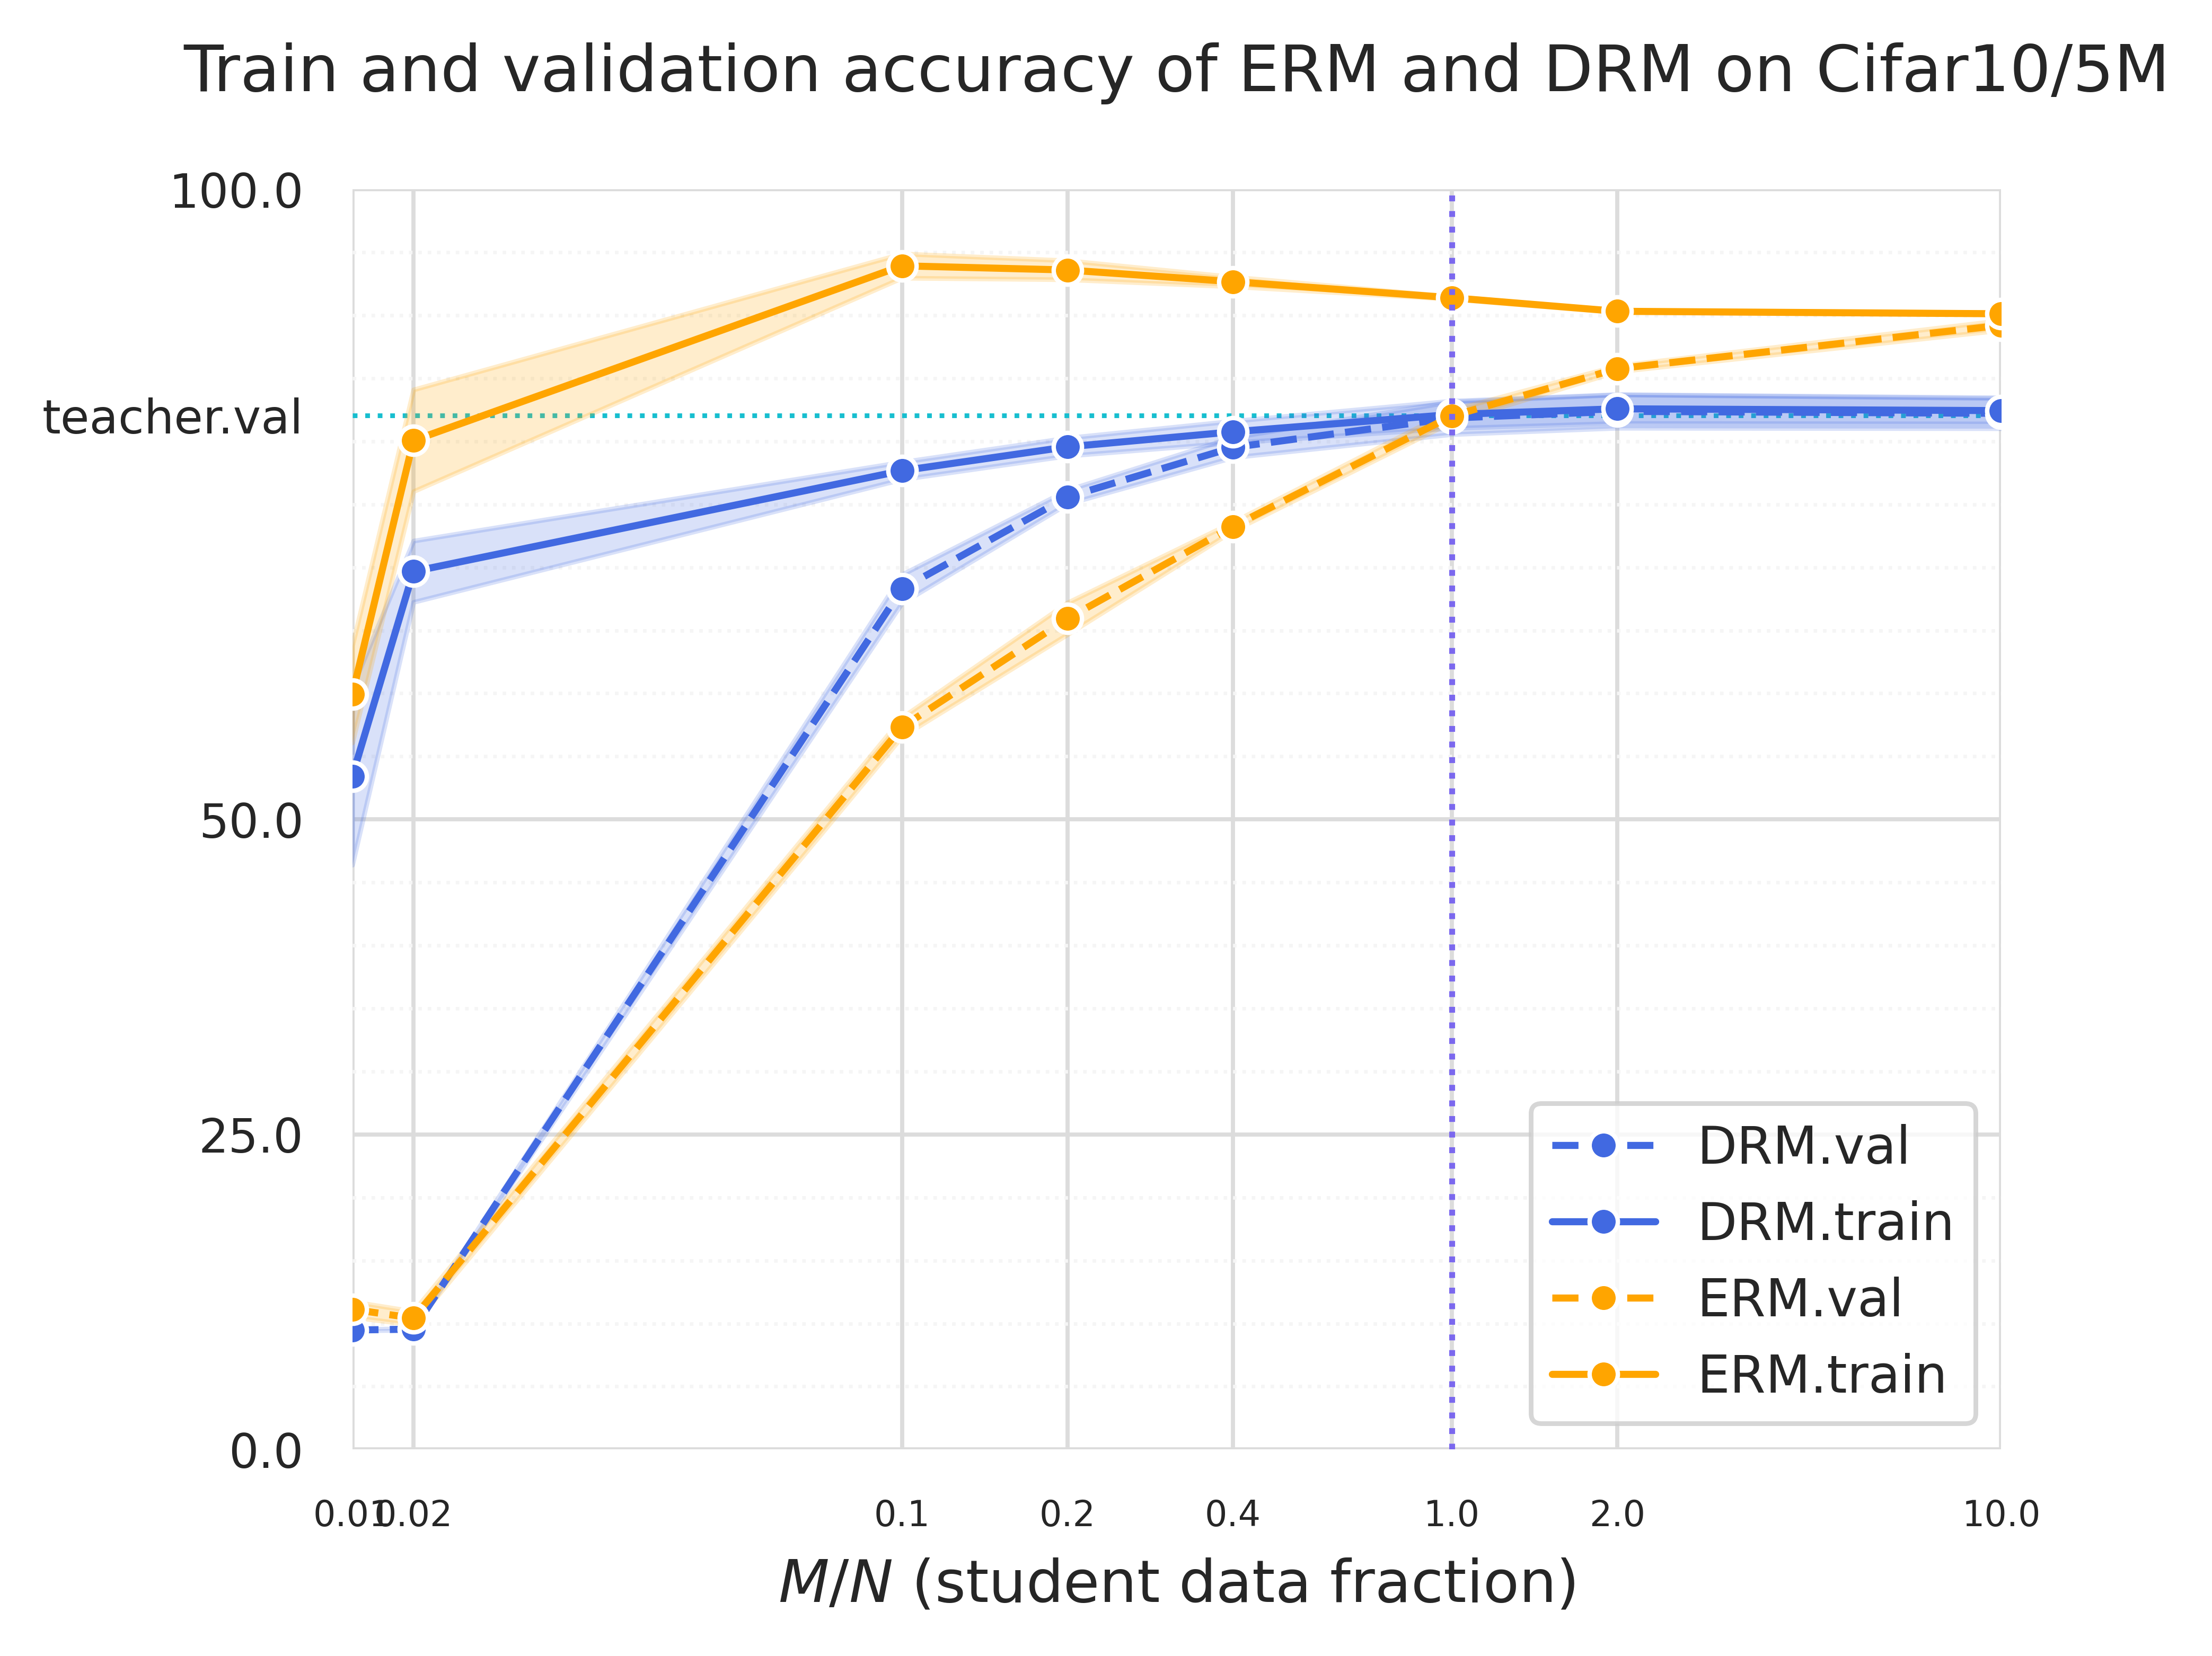

In [11]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,4), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']


    _df = working_df.loc[working_df['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='--',ax=ax, label="distil.val")
    sns.lineplot(data=_df, x="buffer_size_p", y="final_train_acc_S", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='-', ax=ax, label="distil.train")
    _df = working_df.loc[working_df['alpha']==1.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='--', ax=ax, label="labels.val")
    sns.lineplot(data=_df, x="buffer_size_p", y="final_train_acc_S", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='-', ax=ax, label="labels.train")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    # ax.axhline(76.034, ls='--', color=colors[2], label="a")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    #ax.set_xscale('log')
    ax.set_xscale('symlog',linthresh=10e-2)
    ax.set_xlim([0.1,0.4])
    ax.set_ylim([0.0,100.0])

    ax.tick_params(axis='both',  labelsize=9)
    ax.set_xticks(buffer_sizes_p)
    ax.set_xticklabels([ f'{l}' for l in buffer_sizes_p], fontsize=6)
    ax.tick_params(axis='x',  rotation=0)

    yticks = [0.0, 25.0, 50.0, teacher_val_accuracy, 100.0]
    plt.yticks(yticks)
    ax.set_yticklabels([0.0, 25.0, 50.0, 'teacher.val', 100.0], fontsize=8)

    ax.axvline(x=1.0, color='mediumslateblue', linewidth=1.0, linestyle=':')

    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax.set_title(f"Train and validation accuracy of ERM and DRM on Cifar10/5M", fontsize=11, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'$M/N$ (student data fraction)', fontsize=10, y=+1)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, ['DRM.val','DRM.train',
                  'ERM.val','ERM.train',
                  'teacher.val','teacher.train'], 
                title="", ncol=1, loc="lower right")


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.7)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    a = ax.get_ygridlines()
    b = a[3]
    b.set_color('tab:cyan')
    b.set_linewidth(0.8)
    b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()


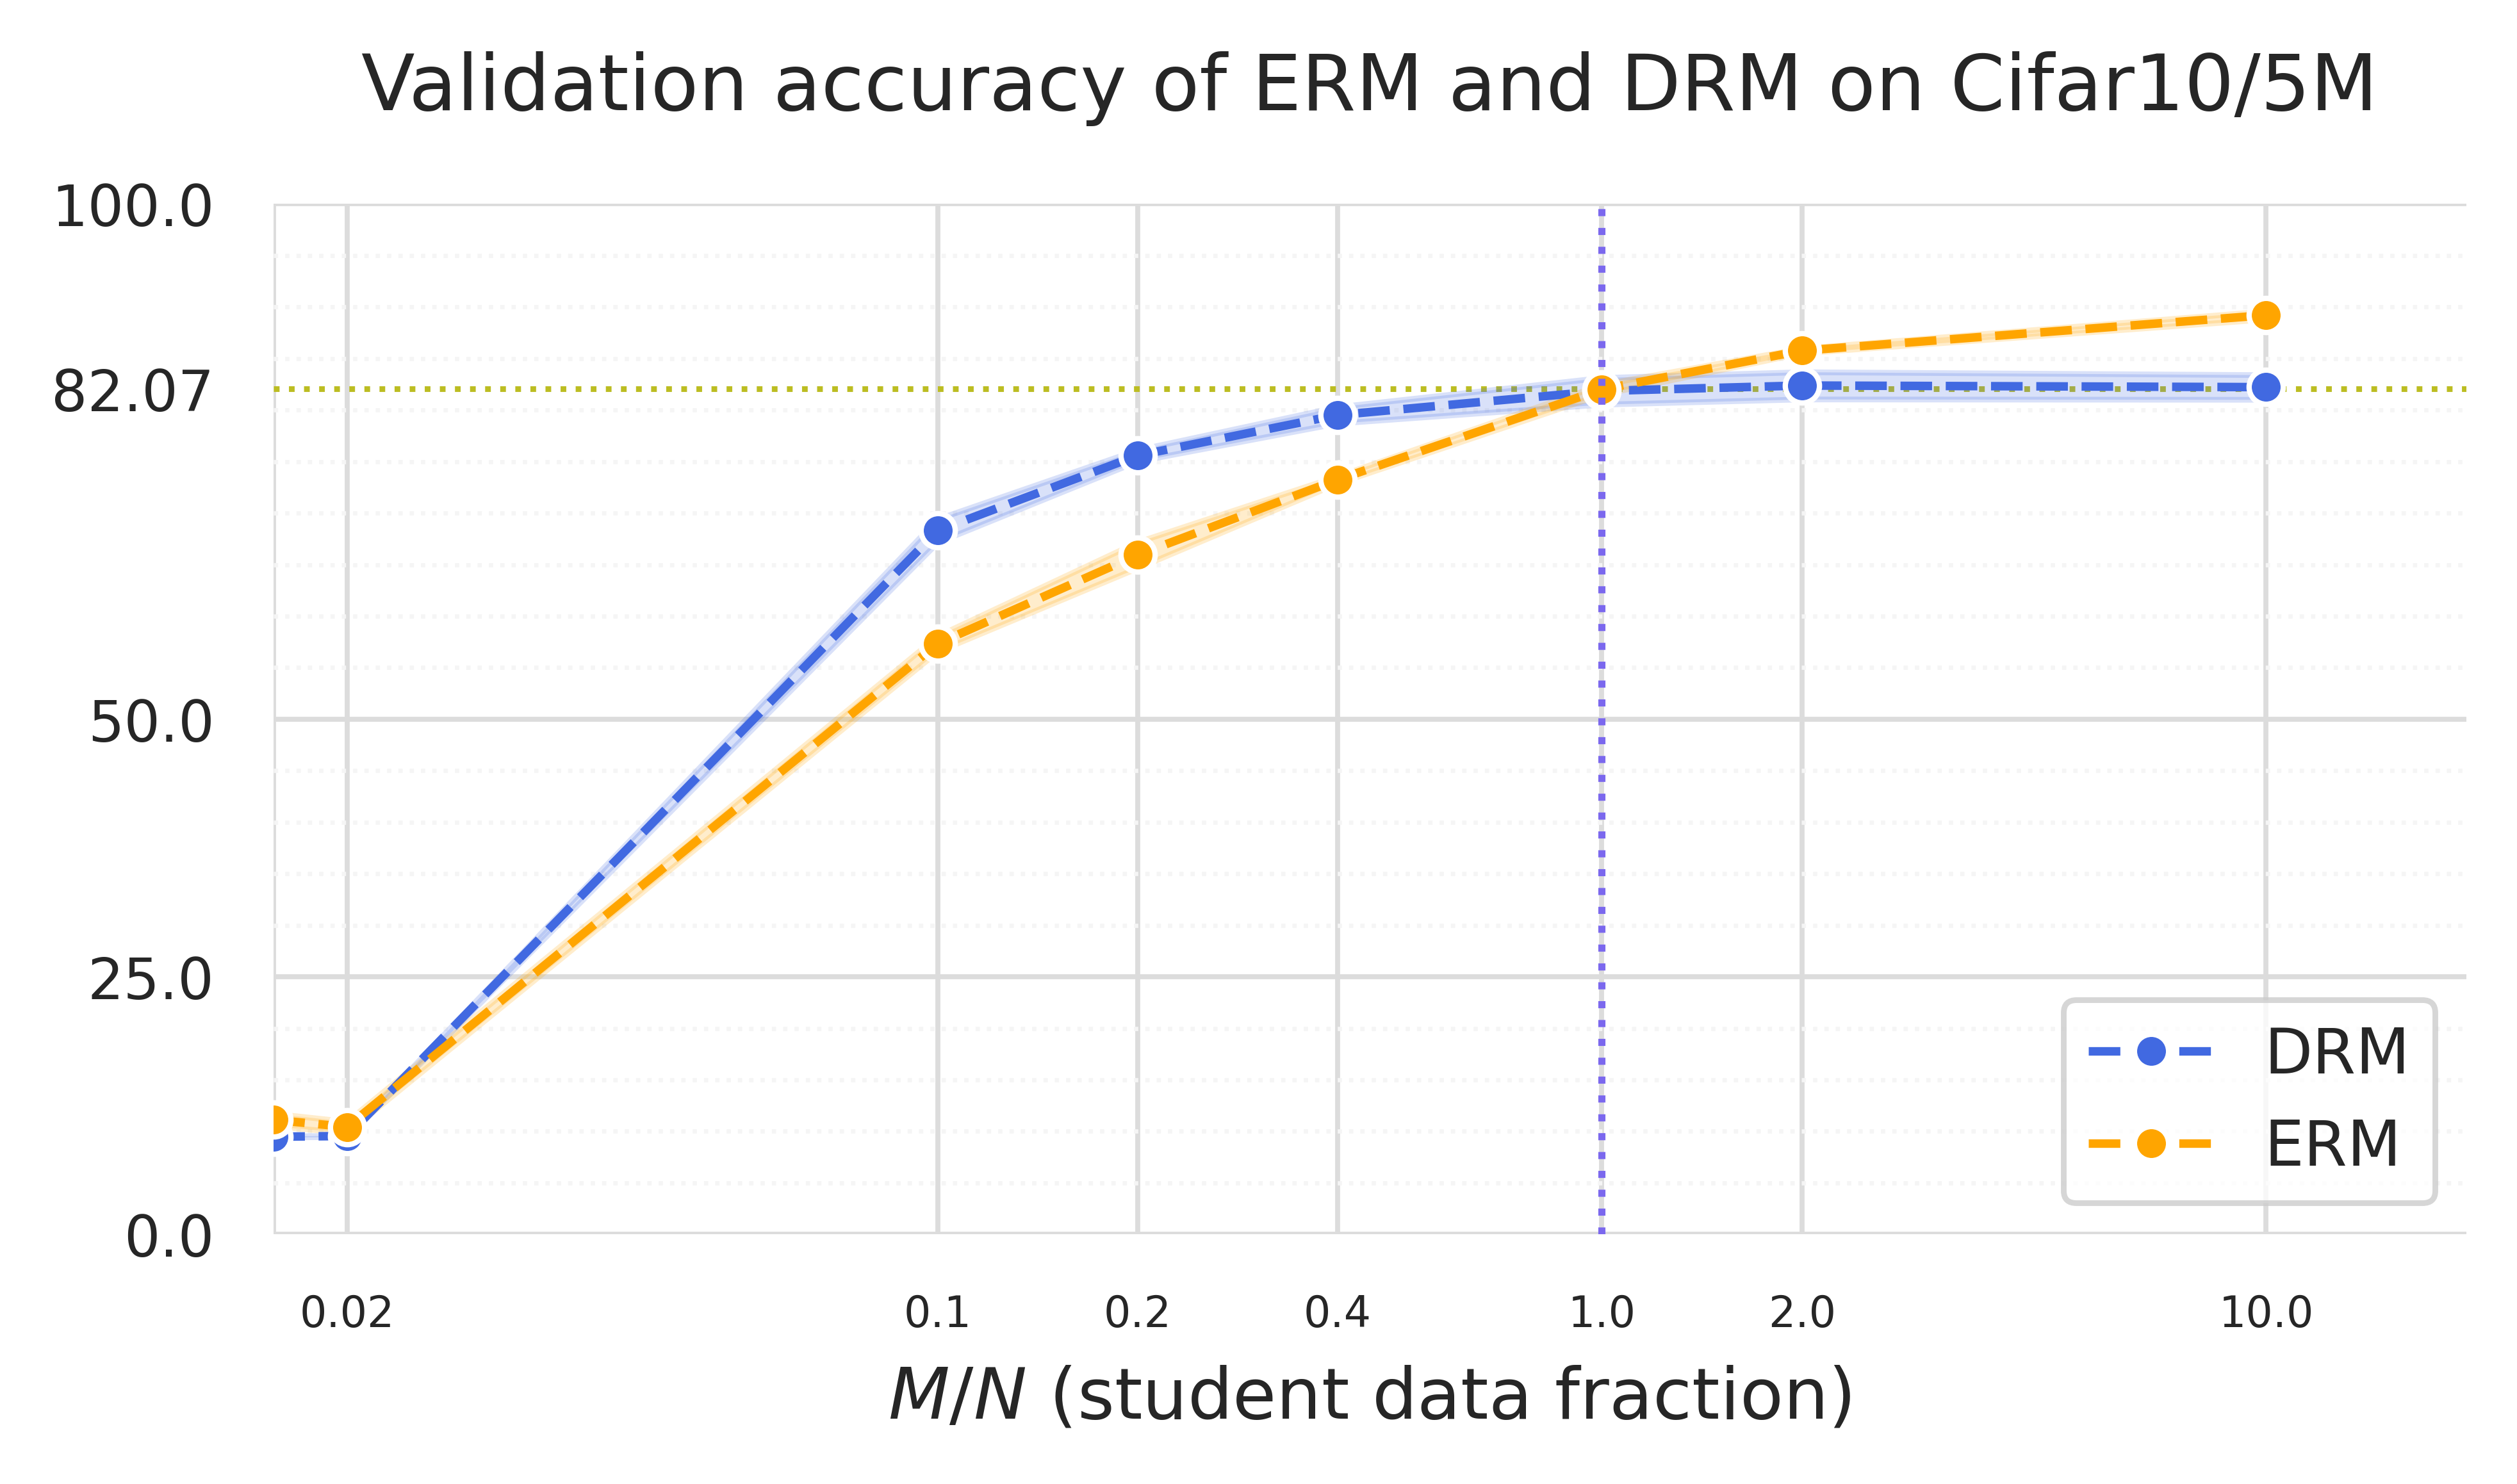

In [12]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,3), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']


    _df = working_df.loc[working_df['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='--',ax=ax, label="distil.val")
    _df = working_df.loc[working_df['alpha']==1.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='--', ax=ax, label="labels.val")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    #ax.axhline(teacher_val_accuracy_rec, ls=':', color="tab:gray")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    #ax.set_xscale('log')
    ax.set_xscale('symlog',linthresh=10e-2)
    ax.set_xlim([0.1,20.])
    ax.set_ylim([0.0,100.0])

    ax.tick_params(axis='both',  labelsize=9)
    ax.set_xticks(buffer_sizes_p)
    ax.set_xticklabels(['']+[ f'{l}' for l in buffer_sizes_p[1:]], fontsize=6)
    ax.tick_params(axis='x',  rotation=0)

    yticks = [0.0, 25.0, 50.0, teacher_val_accuracy, 100.0]
    plt.yticks(yticks)
    ax.set_yticklabels([0.0, 25.0, 50.0, f'{teacher_val_accuracy}', 100.0], fontsize=8)

    ax.axvline(x=1.0, color='mediumslateblue', linewidth=1.0, linestyle=':')

    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax.set_title(f"Validation accuracy of ERM and DRM on Cifar10/5M", fontsize=11, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'$M/N$ (student data fraction)', fontsize=10, y=+1)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, ['DRM',
                  'ERM',
                  'teacher'], 
                title="", ncol=1, loc="lower right")


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.7)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    a = ax.get_ygridlines()
    b = a[3]
    b.set_color('tab:olive')
    b.set_linewidth(0.8)
    b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()


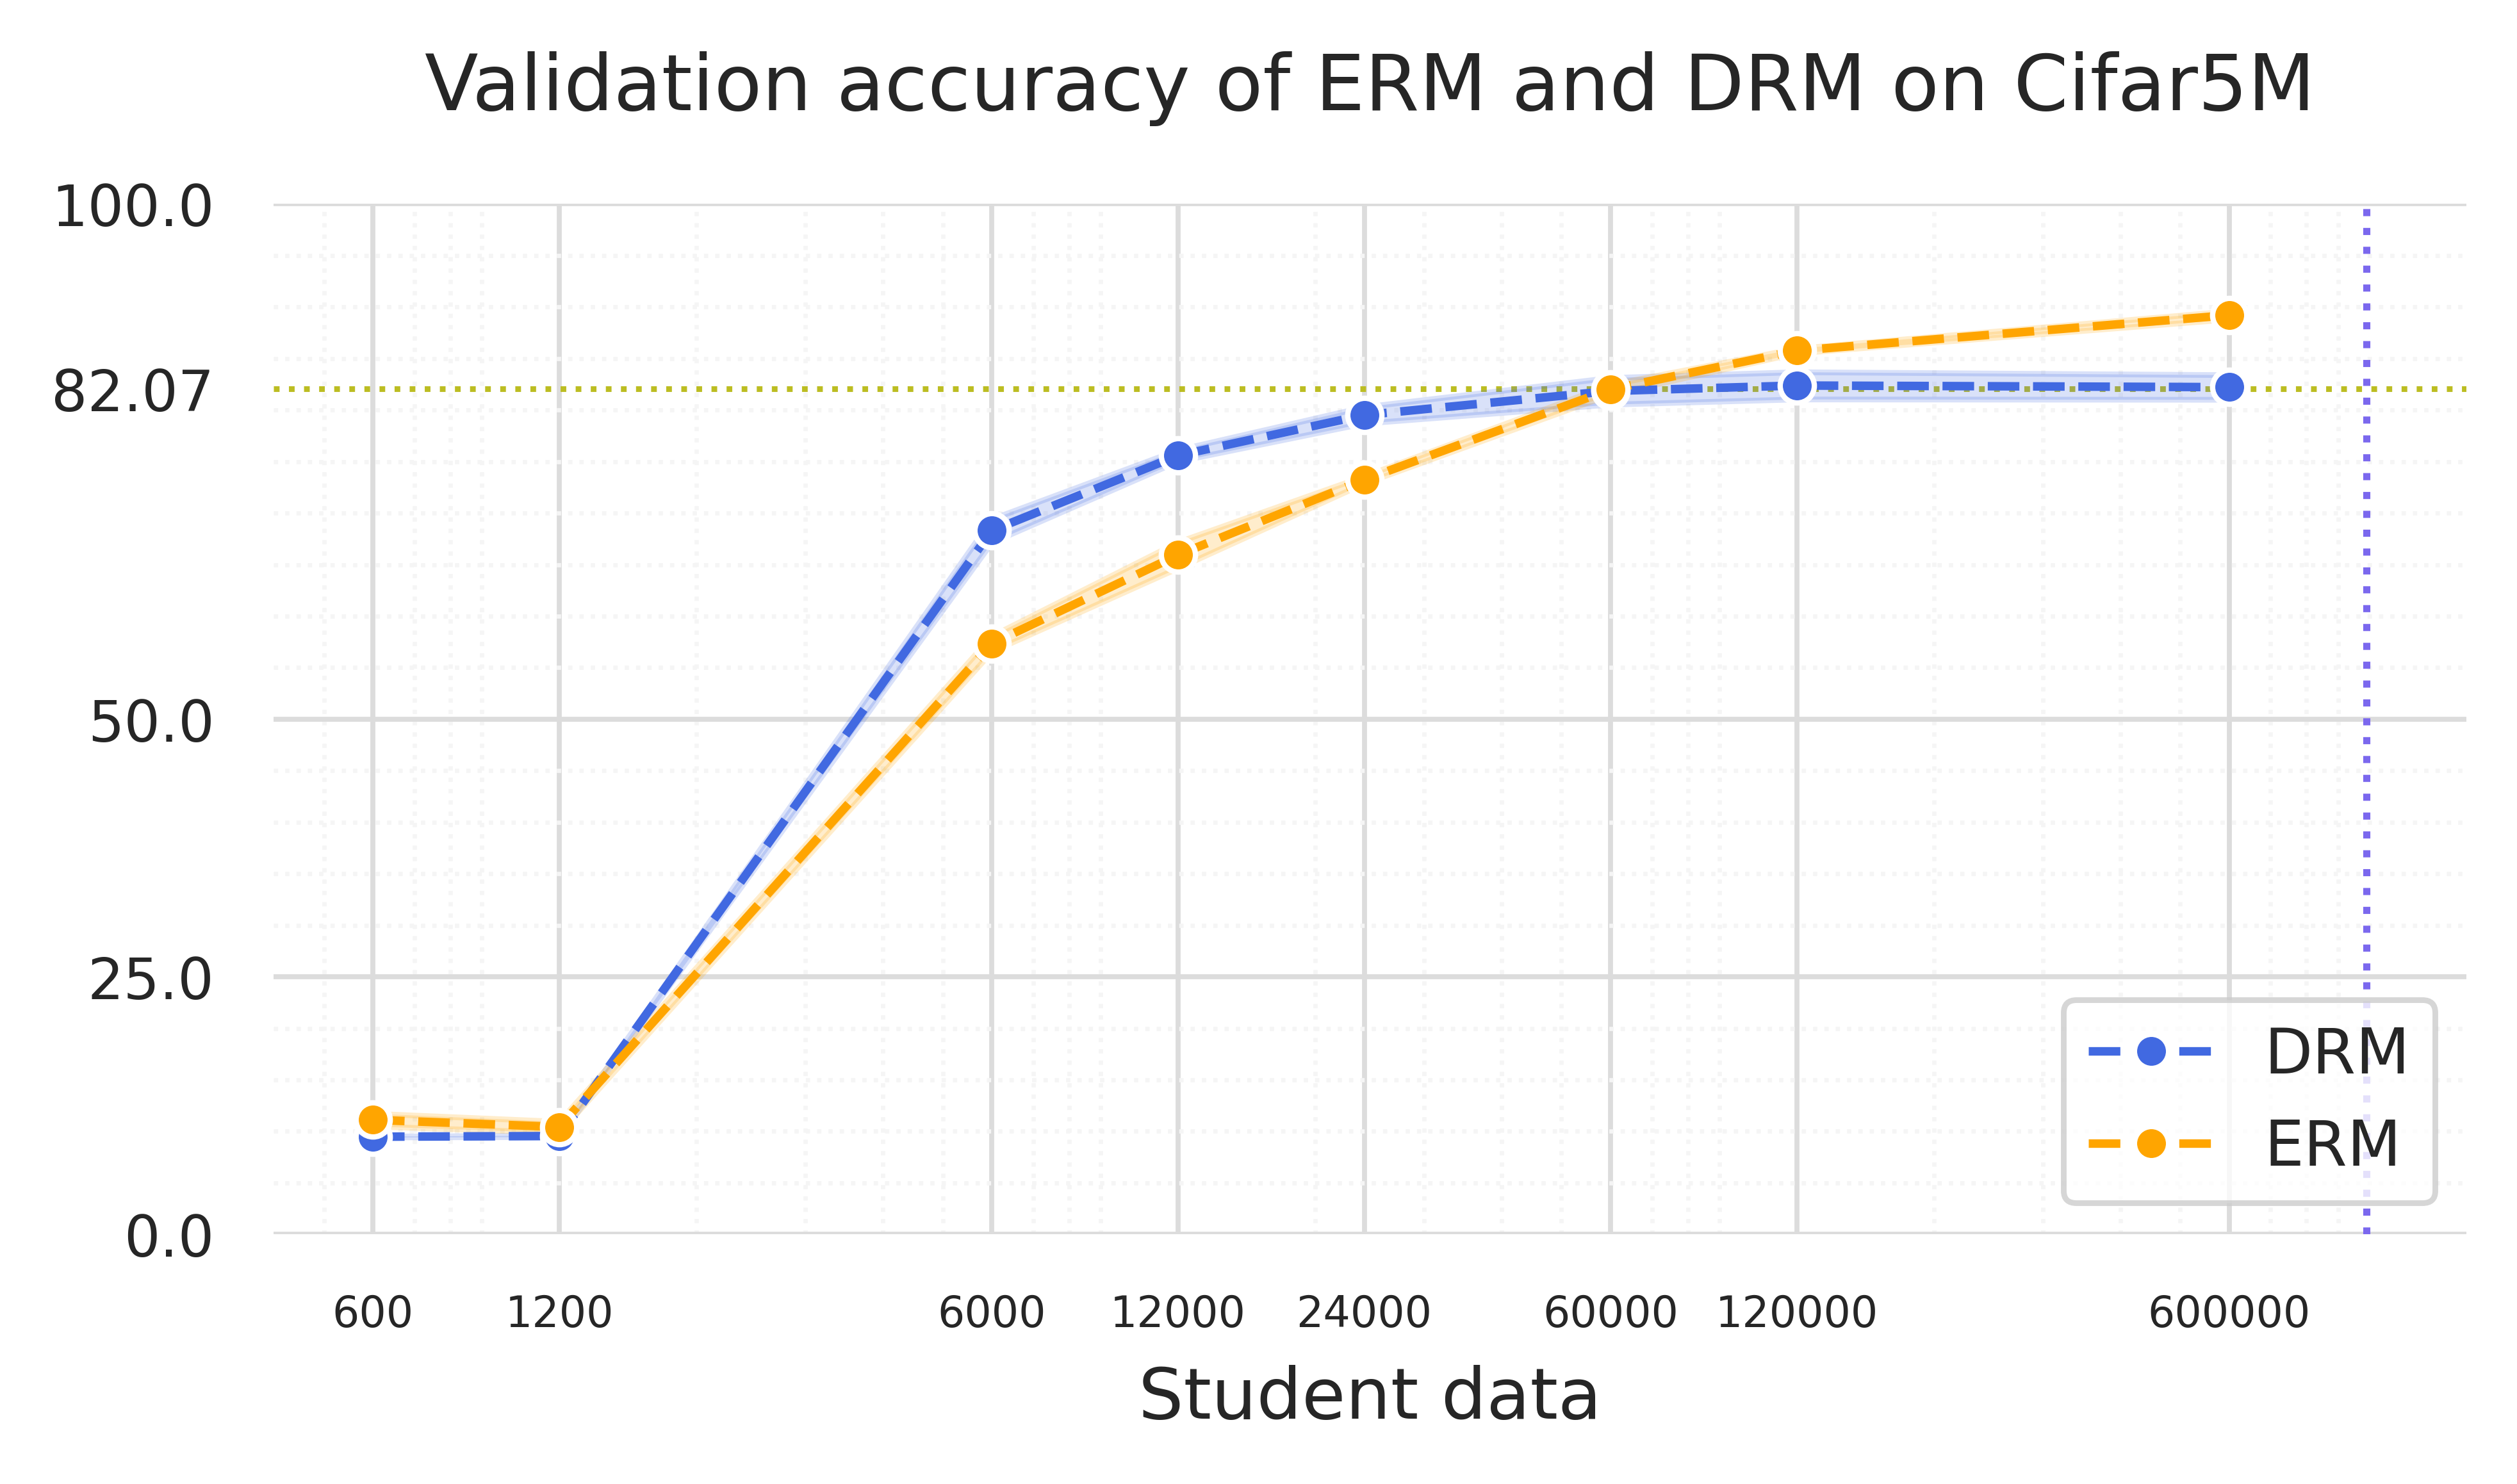

In [13]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,3), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']


    _df = working_df.loc[working_df['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size", y="final_val_acc_S", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='--',ax=ax, label="distil.val")
    _df = working_df.loc[working_df['alpha']==1.0]
    sns.lineplot(data=_df, x="buffer_size", y="final_val_acc_S", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='--', ax=ax, label="labels.val")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    # ax.axhline(76.034, ls='--', color=colors[2], label="a")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    ax.set_xscale('log')
    #ax.set_xscale('symlog',linthresh=10e-2)
    #ax.set_xlim([0.1,0.4])
    ax.set_ylim([0.0,100.0])

    ax.tick_params(axis='both',  labelsize=9)
    ax.set_xticks(buffer_sizes)
    ax.set_xticklabels(buffer_sizes, fontsize=6)
    ax.tick_params(axis='x',  rotation=0)

    yticks = [0.0, 25.0, 50.0, teacher_val_accuracy, 100.0]
    plt.yticks(yticks)
    ax.set_yticklabels([0.0, 25.0, 50.0, teacher_val_accuracy, 100.0], fontsize=8)

    ax.axvline(x=1000000, color='mediumslateblue', linewidth=1.0, linestyle=':')

    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax.set_title(f"Validation accuracy of ERM and DRM on Cifar5M", fontsize=11, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'Student data', fontsize=10, y=+1)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, ['DRM',
                  'ERM',
                  'teacher'], 
                title="", ncol=1, loc="lower right")


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.7)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    a = ax.get_ygridlines()
    b = a[3]
    b.set_color('tab:olive')
    b.set_linewidth(0.8)
    b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()


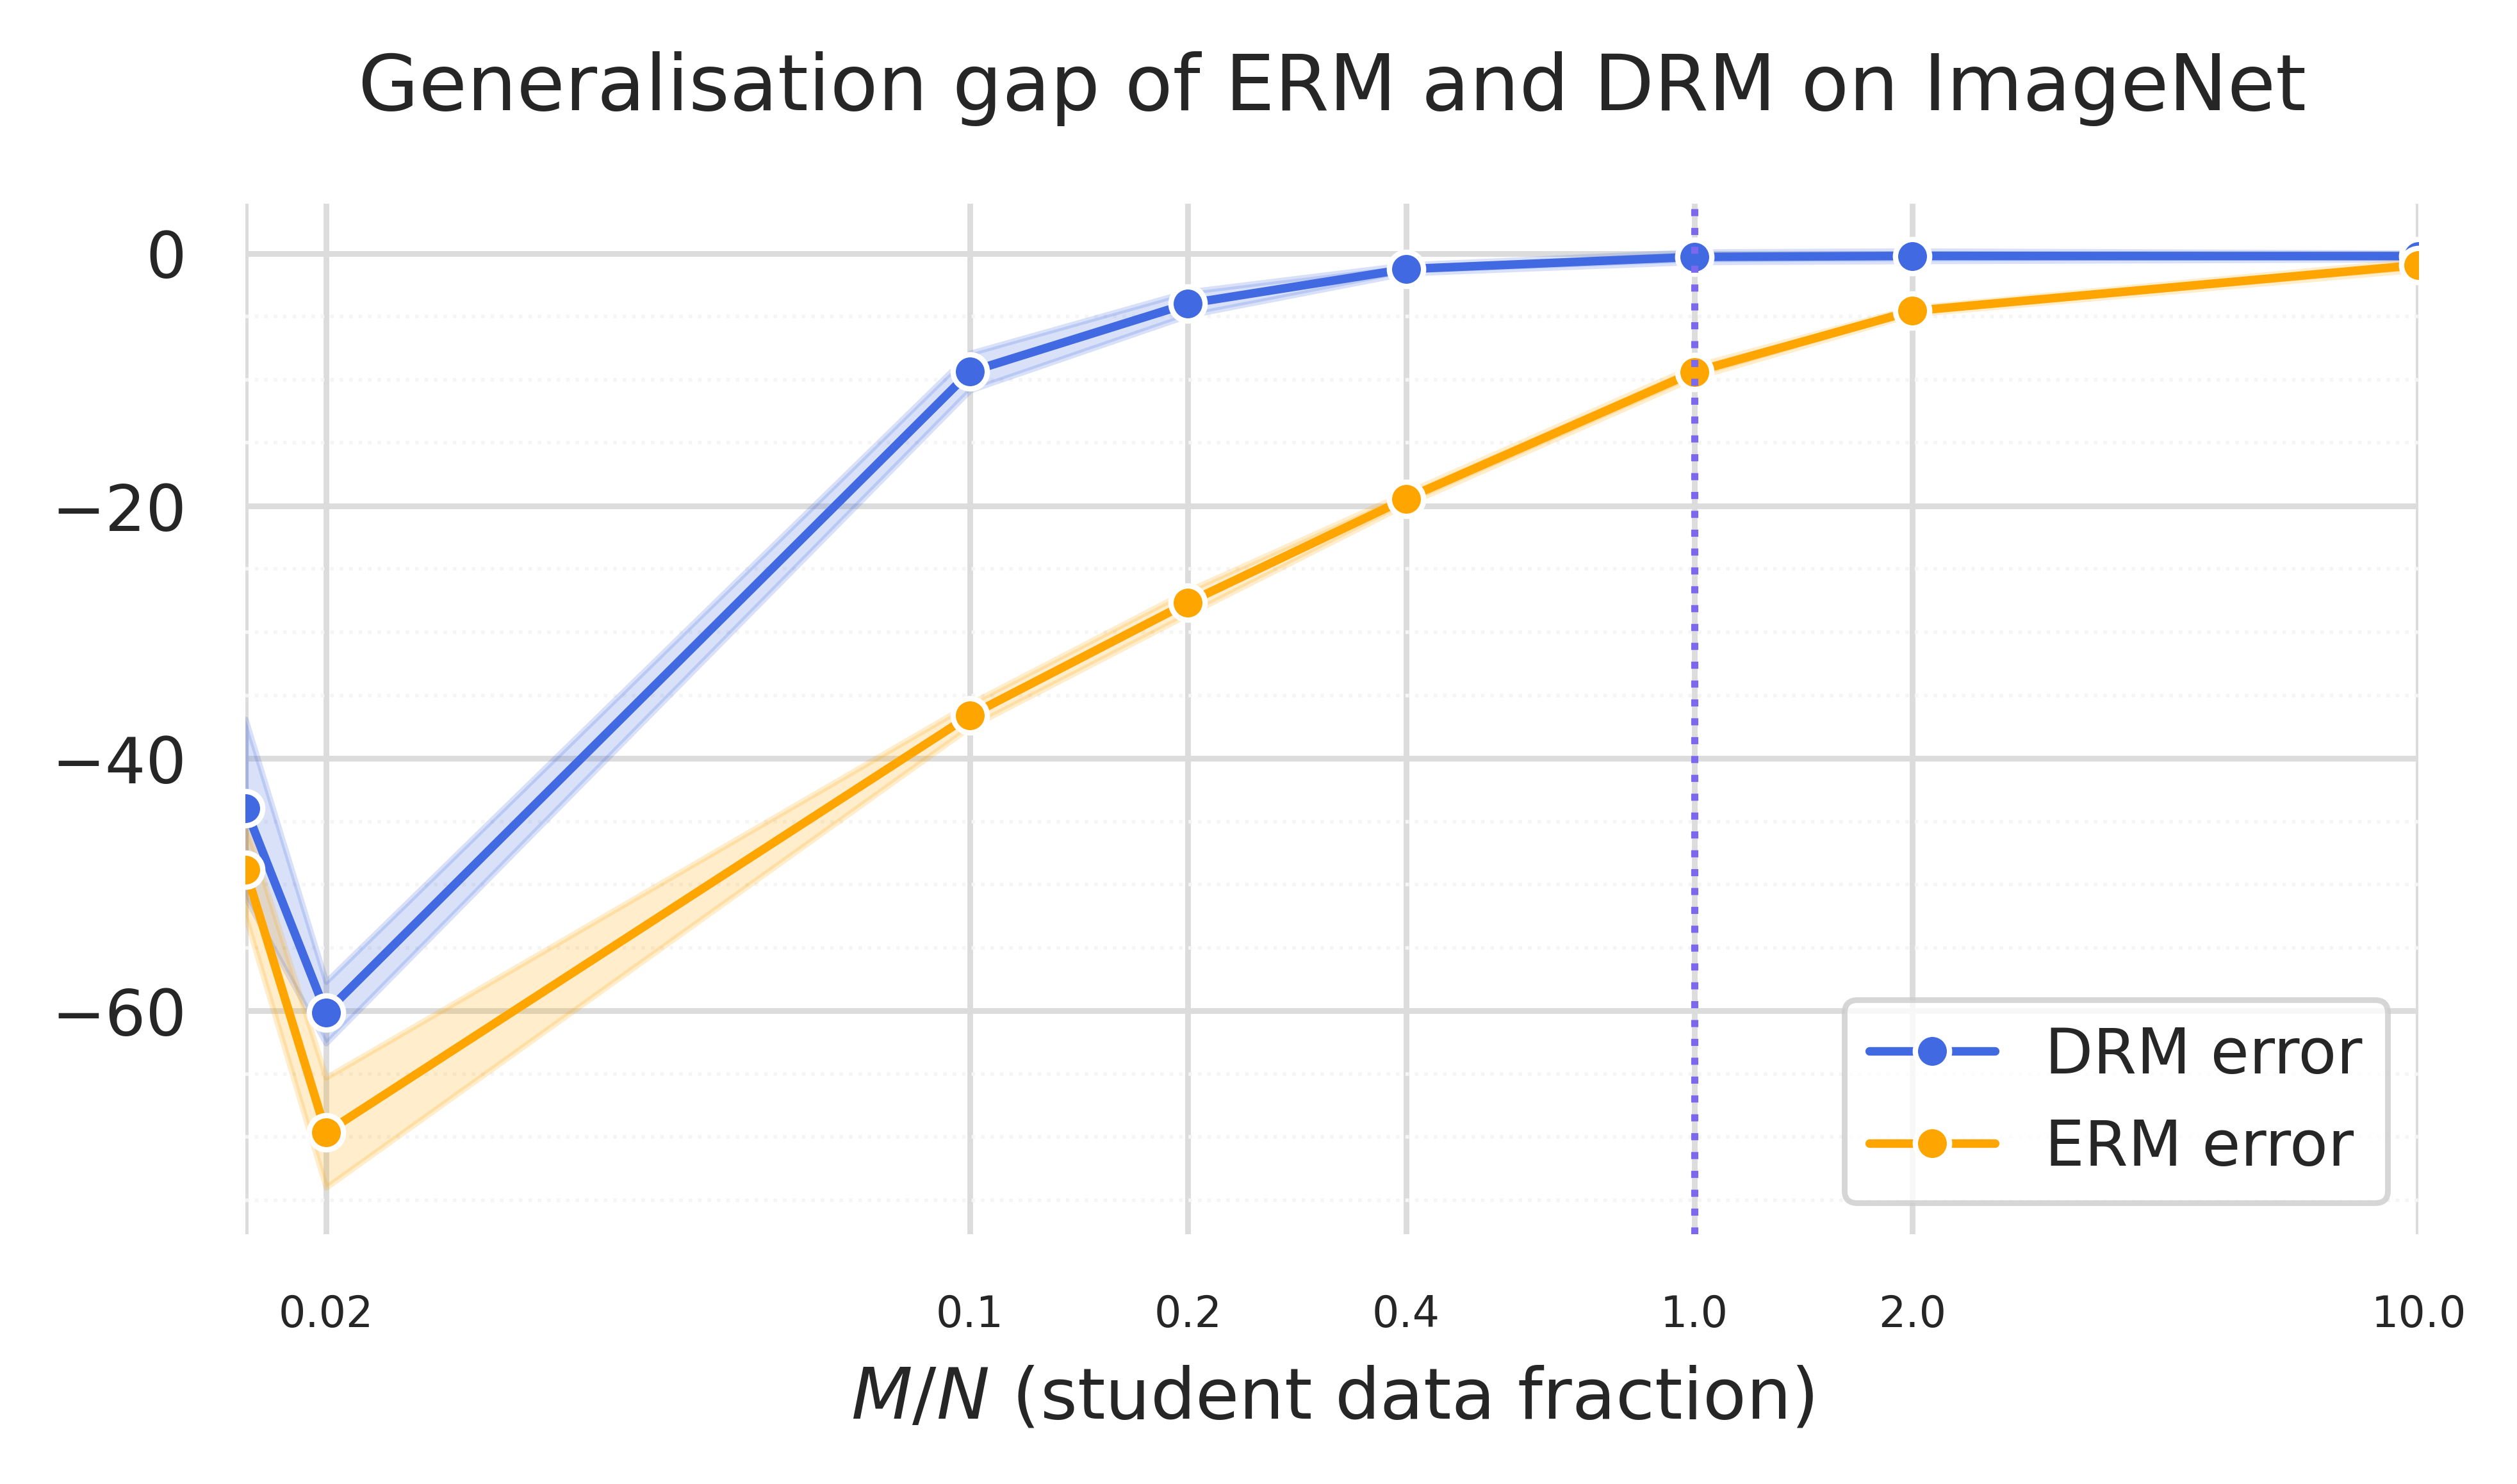

In [16]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,3), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']



    _df = working_df.loc[working_df['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="generalization_gap", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='-', ax=ax, label="DRM error")
    _df = working_df.loc[working_df['alpha']==1.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="generalization_gap", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='-', ax=ax, label="ERM error")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    # ax.axhline(76.034, ls='--', color=colors[2], label="a")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    #ax.set_xscale('log')
    ax.set_xscale('symlog',linthresh=10e-2)
    ax.set_xlim([0.1,0.4])
    #ax.set_ylim([0.0,100.0])

    ax.tick_params(axis='both',  labelsize=9)
    ax.set_xticks(buffer_sizes_p)
    ax.set_xticklabels(['']+[ f'{l}' for l in buffer_sizes_p[1:]], fontsize=6)
    ax.tick_params(axis='x',  rotation=0)

    ax.axvline(x=1.0, color='mediumslateblue', linewidth=1.0, linestyle=':')

    #yticks = [0.0, 25.0, 50.0, teacher_val_accuracy, 100.0]
    #plt.yticks(yticks)
    #ax.set_yticklabels([0.0, 25.0, 50.0, 'teacher.val', 100.0], fontsize=8)



    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax.set_title(f"Generalisation gap of ERM and DRM on ImageNet", fontsize=11, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'$M/N$ (student data fraction)', fontsize=10, y=+1)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, ['DRM error',
                  'ERM error'], 
                title="", ncol=1, loc="lower right")


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.8)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.5)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    a = ax.get_ygridlines()
    b = a[6]
    b.set_color('red')
    b.set_linewidth(0.8)
    b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()


# Cifar 5M big teacher -> small student

In [19]:
logs_path = './logs/results/cifar5m/small/logs.txt'
results = []
with open(logs_path) as f:
    while line := f.readline():
        results.append(json.loads(line))

In [20]:
res_df_small = pd.DataFrame(results)
res_df_small

distributed   lr  checkpoints  pretrained  optim_wd  optim_adam   
0            no  0.1         True       False     0.001       False  \
1            no  0.1         True       False     0.001       False   
2            no  0.1         True       False     0.001       False   
3            no  0.1         True       False     0.001       False   
4            no  0.1         True       False     0.001       False   
..          ...  ...          ...         ...       ...         ...   
117          no  0.1         True       False     0.001       False   
118          no  0.1         True       False     0.001       False   
119          no  0.1         True       False     0.001       False   
120          no  0.1         True       False     0.001       False   
121          no  0.1         True       False     0.001       False   

     optim_mom  optim_warmup  optim_nesterov  optim_cosineanneal  ...    K   
0            0             5           False                True  ...  100  \
1            0             5           False                True  ...  100   
2            0             5           False                True  ...  100   
3            0             5           False                True  ...  100   
4            0             5           False                True  ...  100   
..         ...           ...             ...                 ...  ...  ...   
117          0             5           False                True  ...  100   
118          0             5           False                True  ...  100   
119          0             5           False                True  ...  100   
120          0             5           False                True  ...  100   
121          0             5           False                True  ...  100   

     N_BLOCKS  gamma  final_val_acc_D buffer_train_time  final_train_acc_S   
0           1    1.0            85.95        771.529704          91.430000  \
1           1    1.0            85.95        779.120204          81.365000   
2           1    1.0            85.95        257.423453          65.600000   
3           1    1.0            85.95        267.612314          79.500000   
4           1    1.0            85.95        268.595036          62.300000   
..        ...    ...              ...               ...                ...   
117         1    1.0            85.95        530.127717          81.529167   
118         1    1.0            85.95        552.669076          81.825000   
119         1    1.0            85.95        894.300130          92.304167   
120         1    1.0            85.95        892.361585          92.250000   
121         1    1.0            85.95        896.302919          92.054167   

    final_val_acc_S  final_train_agreement  final_val_agreement   
0             69.71              83.405000                71.64  \
1             79.36              86.815000                83.88   
2              9.47              68.500000                 8.71   
3             10.67              71.900000                11.32   
4              9.60              64.500000                10.41   
..              ...                    ...                  ...   
117           80.33              86.791667                84.77   
118           79.90              87.004167                84.50   
119           73.78              84.708333                75.60   
120           73.02              84.016667                74.53   
121           72.47              84.308333                75.25   

     final_val_function_distance  
0                       0.285505  
1                       0.159231  
2                       0.728220  
3                       0.730435  
4                       0.728139  
..                           ...  
117                     0.149032  
118                     0.152915  
119                     0.249485  
120                     0.259479  
121                     0.255858  

[122 rows x 41 columns]

In [21]:
res_df_small.columns

Index(['distributed', 'lr', 'checkpoints', 'pretrained', 'optim_wd',
       'optim_adam', 'optim_mom', 'optim_warmup', 'optim_nesterov',
       'optim_cosineanneal', 'n_epochs', 'n_epochs_stud', 'batch_size',
       'validate_subset', 'gpus_id', 'seed', 'notes', 'non_verbose',
       'disable_log', 'validation', 'ignore_other_metrics', 'debug_mode',
       'nowand', 'wandb_entity', 'wandb_project', 'wandb_name', 'buffer_size',
       'minibatch_size', 'alpha', 'MSE', 'distillation_type', 'K', 'N_BLOCKS',
       'gamma', 'final_val_acc_D', 'buffer_train_time', 'final_train_acc_S',
       'final_val_acc_S', 'final_train_agreement', 'final_val_agreement',
       'final_val_function_distance'],
      dtype='object')

In [22]:
buffer_sizes_sm = sorted(list(res_df_small['buffer_size'].unique()))
buffer_sizes_sm

[600,
 1000,
 1200,
 6000,
 10000,
 12000,
 20000,
 24000,
 100000,
 200000,
 400000,
 1000000]

In [23]:
teacher_val_accuracy_sm = res_df_small['final_val_acc_D'][0]
teacher_val_accuracy_sm # the teacher was trained on 1MLN samples from CIFAR 5M

85.95

In [24]:
res_df_small['buffer_size_p'] = res_df_small['buffer_size']/1000000
res_df_small['generalization_gap'] = res_df_small['final_val_acc_S']-res_df_small['final_train_acc_S']
working_df_sm = res_df_small
working_df_sm

distributed   lr  checkpoints  pretrained  optim_wd  optim_adam   
0            no  0.1         True       False     0.001       False  \
1            no  0.1         True       False     0.001       False   
2            no  0.1         True       False     0.001       False   
3            no  0.1         True       False     0.001       False   
4            no  0.1         True       False     0.001       False   
..          ...  ...          ...         ...       ...         ...   
117          no  0.1         True       False     0.001       False   
118          no  0.1         True       False     0.001       False   
119          no  0.1         True       False     0.001       False   
120          no  0.1         True       False     0.001       False   
121          no  0.1         True       False     0.001       False   

     optim_mom  optim_warmup  optim_nesterov  optim_cosineanneal  ...  gamma   
0            0             5           False                True  ...    1.0  \
1            0             5           False                True  ...    1.0   
2            0             5           False                True  ...    1.0   
3            0             5           False                True  ...    1.0   
4            0             5           False                True  ...    1.0   
..         ...           ...             ...                 ...  ...    ...   
117          0             5           False                True  ...    1.0   
118          0             5           False                True  ...    1.0   
119          0             5           False                True  ...    1.0   
120          0             5           False                True  ...    1.0   
121          0             5           False                True  ...    1.0   

     final_val_acc_D  buffer_train_time  final_train_acc_S final_val_acc_S   
0              85.95         771.529704          91.430000           69.71  \
1              85.95         779.120204          81.365000           79.36   
2              85.95         257.423453          65.600000            9.47   
3              85.95         267.612314          79.500000           10.67   
4              85.95         268.595036          62.300000            9.60   
..               ...                ...                ...             ...   
117            85.95         530.127717          81.529167           80.33   
118            85.95         552.669076          81.825000           79.90   
119            85.95         894.300130          92.304167           73.78   
120            85.95         892.361585          92.250000           73.02   
121            85.95         896.302919          92.054167           72.47   

     final_train_agreement final_val_agreement  final_val_function_distance   
0                83.405000               71.64                     0.285505  \
1                86.815000               83.88                     0.159231   
2                68.500000                8.71                     0.728220   
3                71.900000               11.32                     0.730435   
4                64.500000               10.41                     0.728139   
..                     ...                 ...                          ...   
117              86.791667               84.77                     0.149032   
118              87.004167               84.50                     0.152915   
119              84.708333               75.60                     0.249485   
120              84.016667               74.53                     0.259479   
121              84.308333               75.25                     0.255858   

     buffer_size_p  generalization_gap  
0            0.020          -21.720000  
1            0.020           -2.005000  
2            0.001          -56.130000  
3            0.001          -68.830000  
4            0.001          -52.700000  
..             ...                 ...  
117          0.02

In [25]:
buffer_sizes_p_sm = sorted(working_df_sm['buffer_size_p'].unique())
buffer_sizes_p_sm

[0.0006, 0.001, 0.0012, 0.006, 0.01, 0.012, 0.02, 0.024, 0.1, 0.2, 0.4, 1.0]

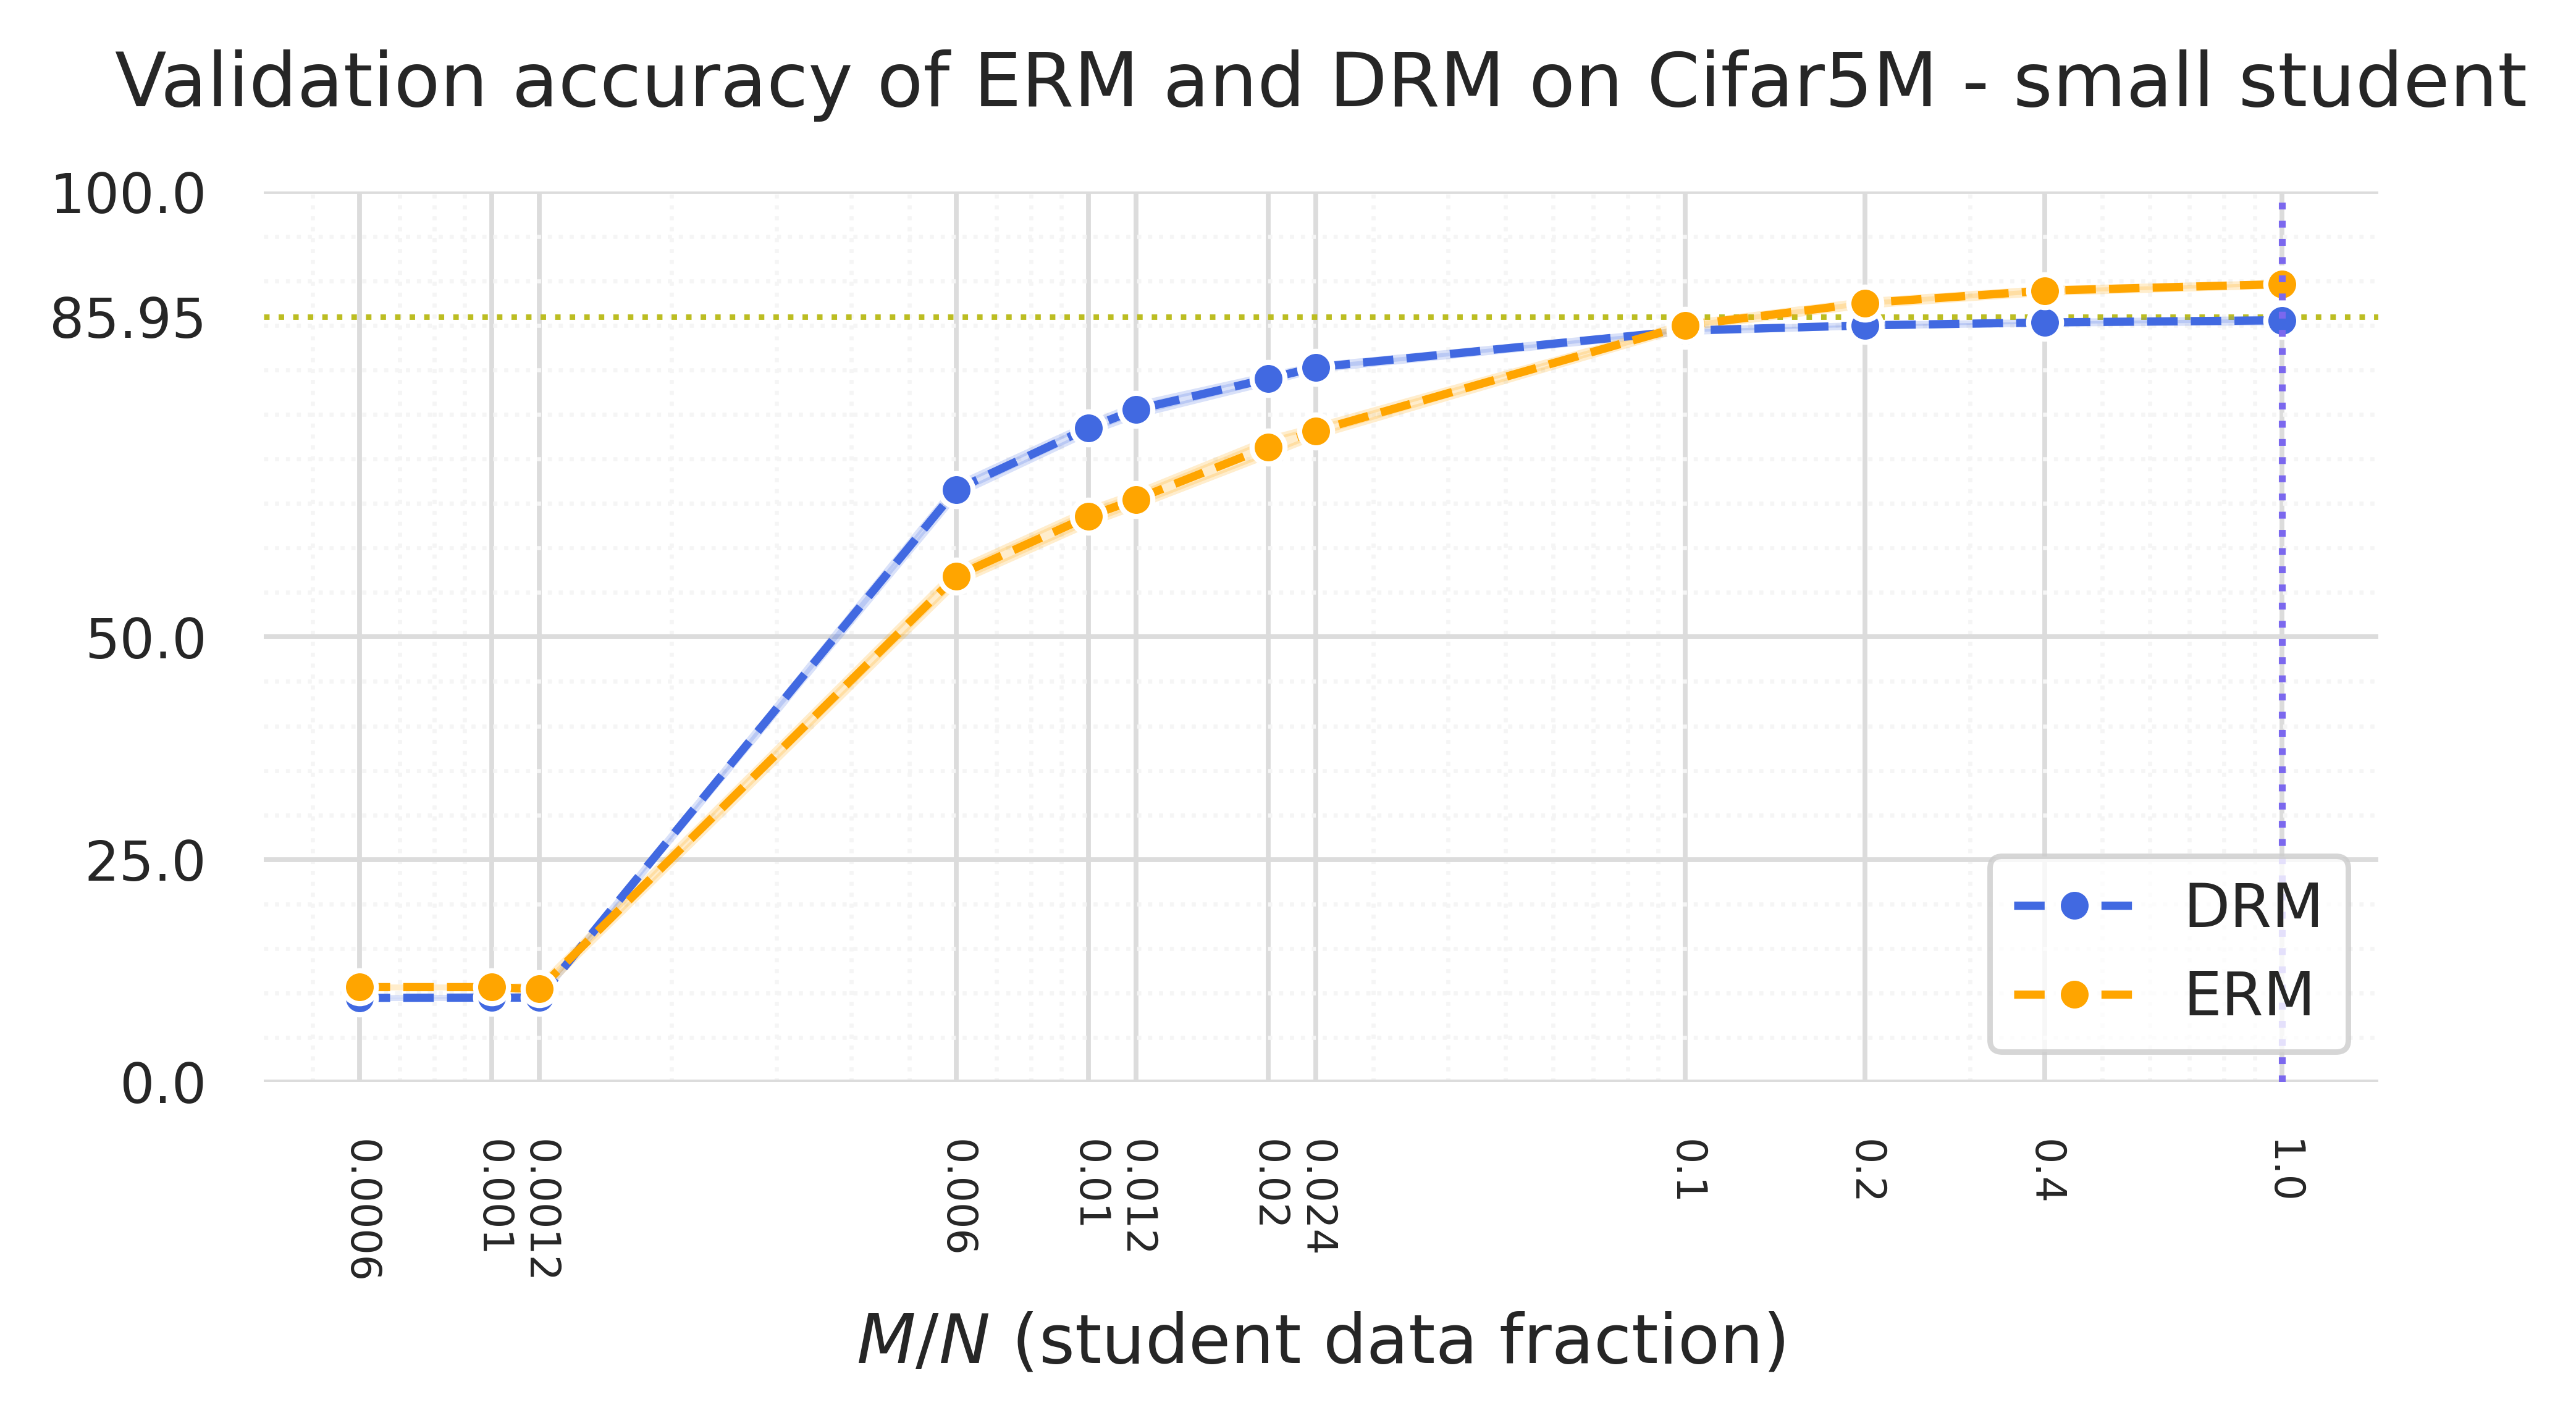

In [26]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,3), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']


    _df = working_df_sm.loc[working_df_sm['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='--',ax=ax, label="distil.val")
    _df = working_df_sm.loc[working_df_sm['alpha']==1.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='--', ax=ax, label="labels.val")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    # ax.axhline(76.034, ls='--', color=colors[2], label="a")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    ax.set_xscale('log')
    #ax.set_xscale('symlog',linthresh=10e-2)
    #ax.set_xlim([0.1,0.4])
    ax.set_ylim([0.0,100.0])

    ax.tick_params(axis='both',  labelsize=9)
    ax.set_xticks(buffer_sizes_p_sm)
    ax.set_xticklabels([ f'{l}' for l in buffer_sizes_p_sm[:]], fontsize=6)
    ax.tick_params(axis='x',  rotation=-90)

    yticks = [0.0, 25.0, 50.0, teacher_val_accuracy_sm, 100.0]
    plt.yticks(yticks)
    ax.set_yticklabels([0.0, 25.0, 50.0, teacher_val_accuracy_sm, 100.0], fontsize=8)

    ax.axvline(x=1.0, color='mediumslateblue', linewidth=1.0, linestyle=':')

    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax.set_title(f"Validation accuracy of ERM and DRM on Cifar5M - small student", fontsize=11, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'$M/N$ (student data fraction)', fontsize=10, y=+1)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, ['DRM',
                  'ERM',
                  'teacher'], 
                title="", ncol=1, loc="lower right")


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.7)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    a = ax.get_ygridlines()
    b = a[3]
    b.set_color('tab:olive')
    b.set_linewidth(0.8)
    b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()


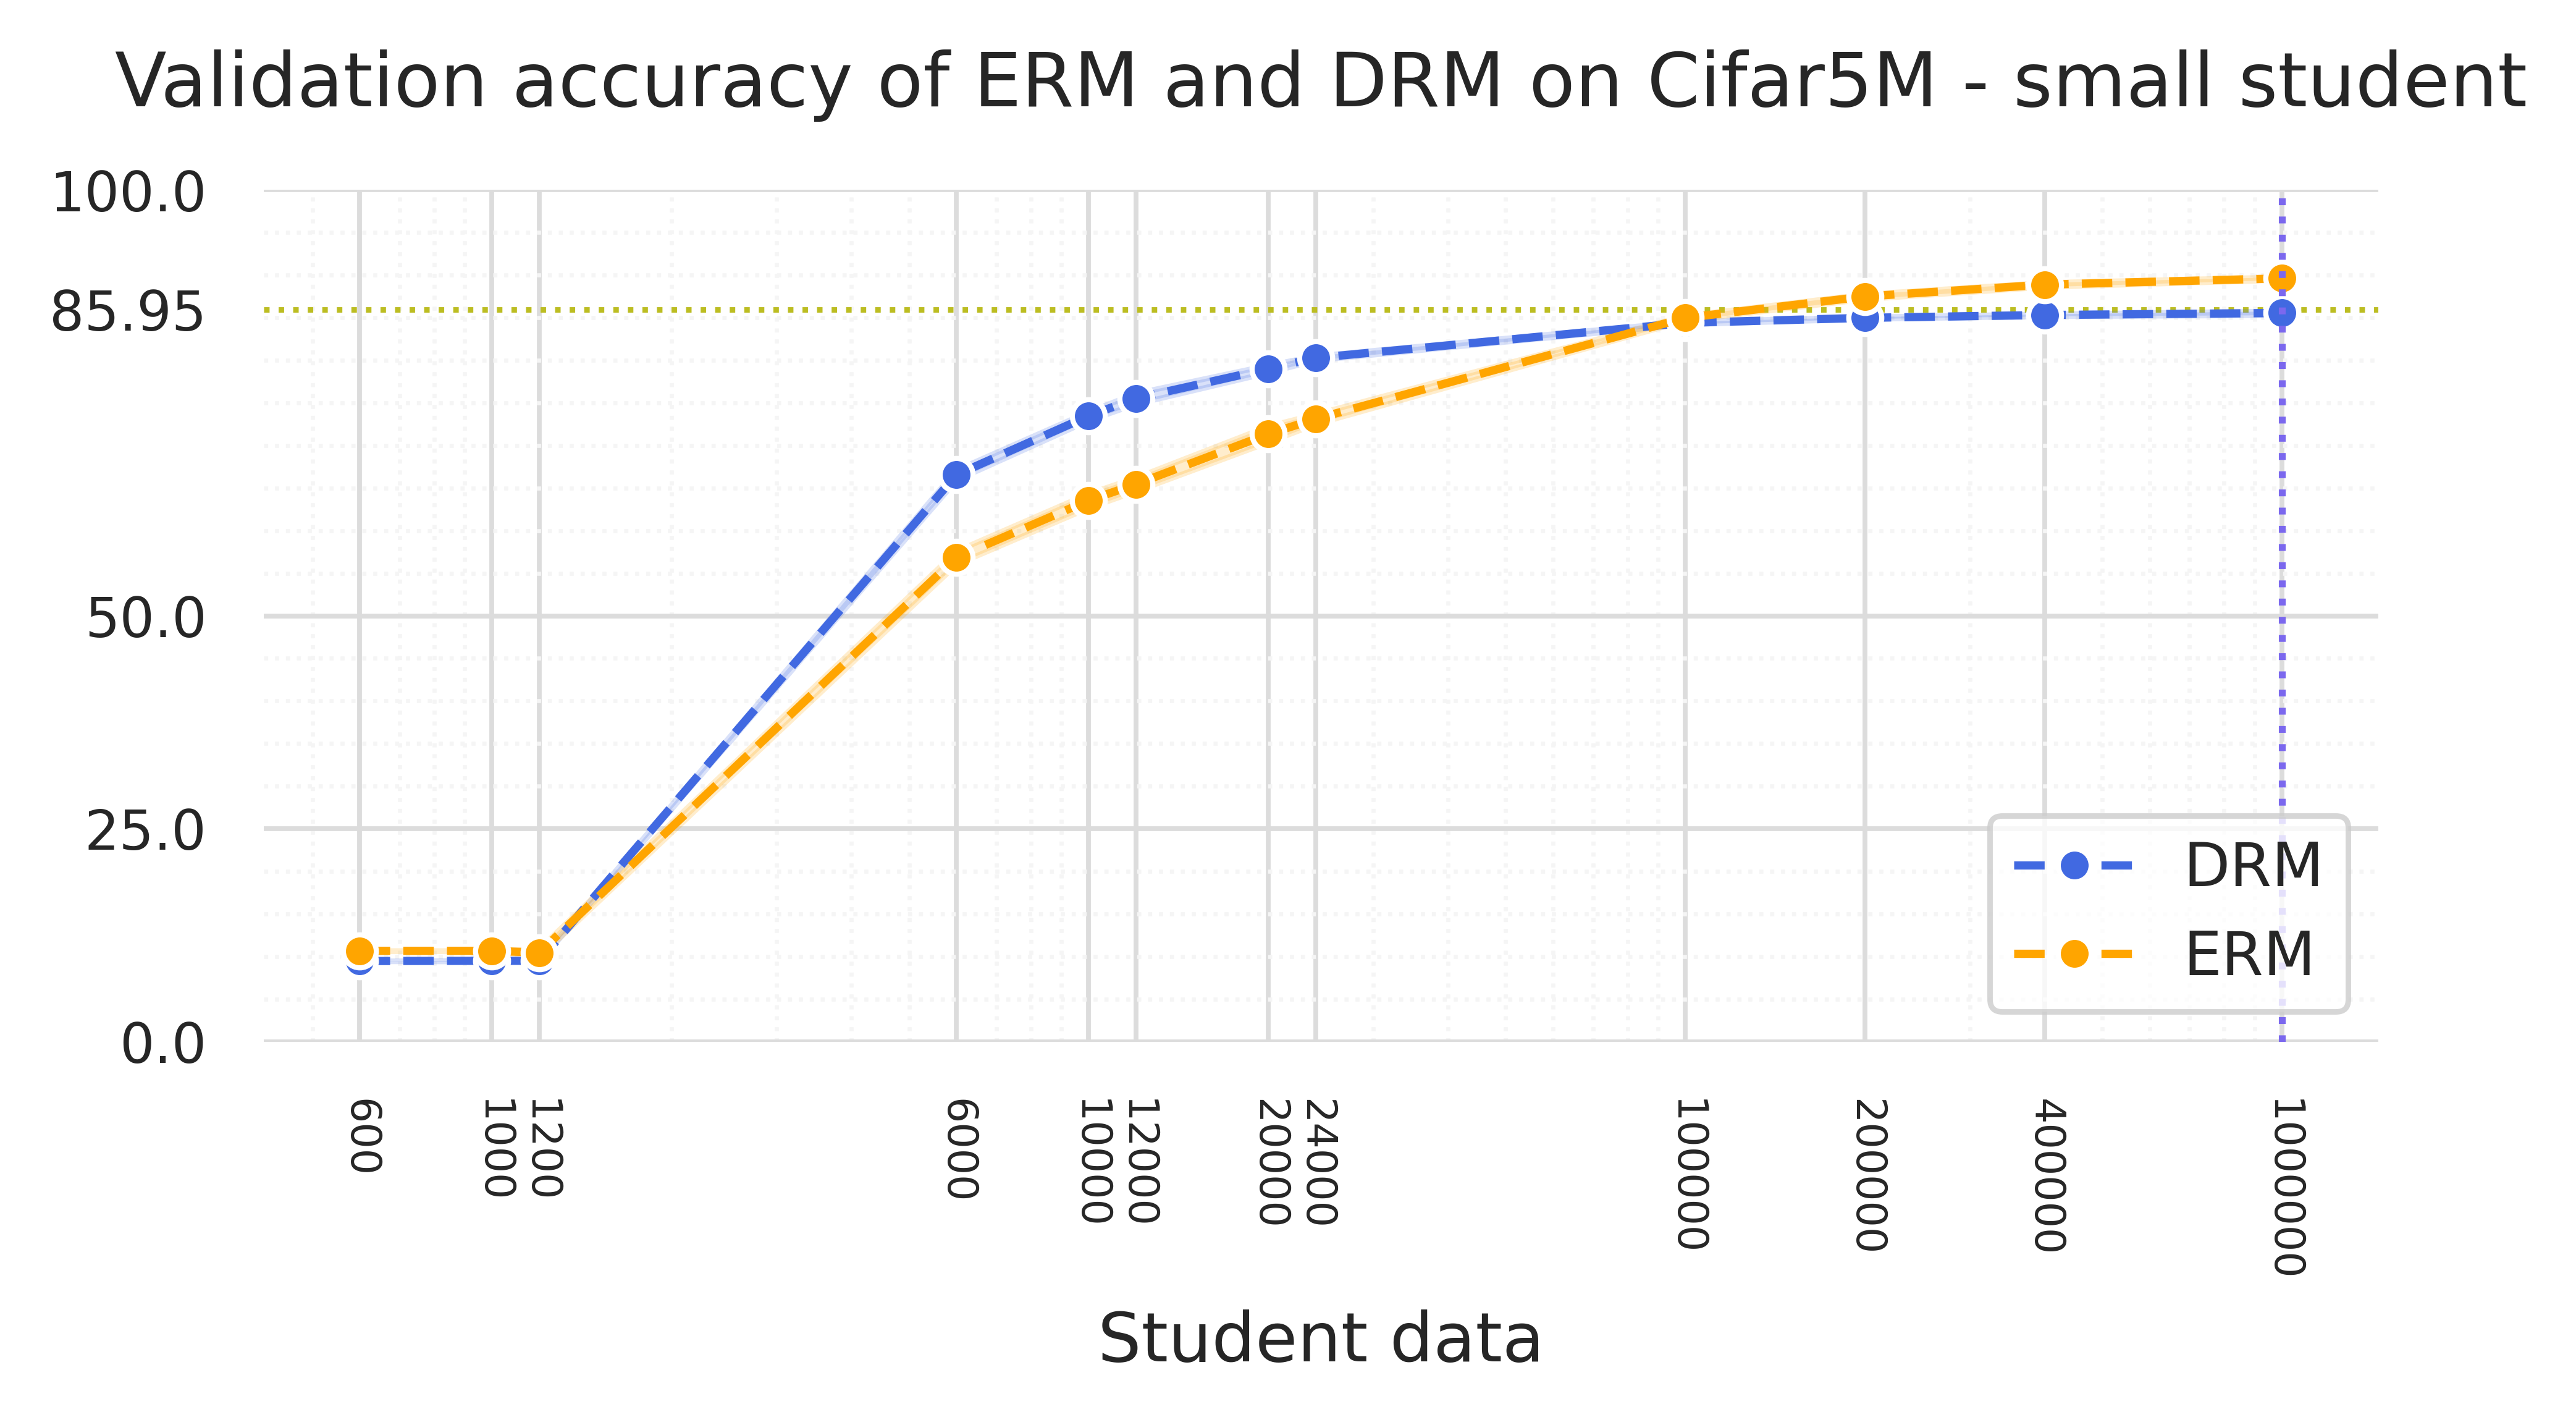

In [28]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,3), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']


    _df = working_df_sm.loc[working_df_sm['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size", y="final_val_acc_S", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='--',ax=ax, label="distil.val")
    _df = working_df_sm.loc[working_df_sm['alpha']==1.0]
    sns.lineplot(data=_df, x="buffer_size", y="final_val_acc_S", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='--', ax=ax, label="labels.val")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    # ax.axhline(76.034, ls='--', color=colors[2], label="a")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    ax.set_xscale('log')
    #ax.set_xscale('symlog',linthresh=10e-2)
    #ax.set_xlim([0.1,0.4])
    ax.set_ylim([0.0,100.0])

    ax.tick_params(axis='both',  labelsize=9)
    ax.set_xticks(buffer_sizes_sm)
    ax.set_xticklabels(buffer_sizes_sm, fontsize=6)
    ax.tick_params(axis='x',  rotation=-90)

    yticks = [0.0, 25.0, 50.0, teacher_val_accuracy_sm, 100.0]
    plt.yticks(yticks)
    ax.set_yticklabels([0.0, 25.0, 50.0, teacher_val_accuracy_sm, 100.0], fontsize=8)

    ax.axvline(x=1000000, color='mediumslateblue', linewidth=1.0, linestyle=':')

    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax.set_title(f"Validation accuracy of ERM and DRM on Cifar5M - small student", fontsize=11, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'Student data', fontsize=10, y=+2)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, ['DRM',
                  'ERM',
                  'teacher'], 
                title="", ncol=1, loc="lower right")


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.7)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    a = ax.get_ygridlines()
    b = a[3]
    b.set_color('tab:olive')
    b.set_linewidth(0.8)
    b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()


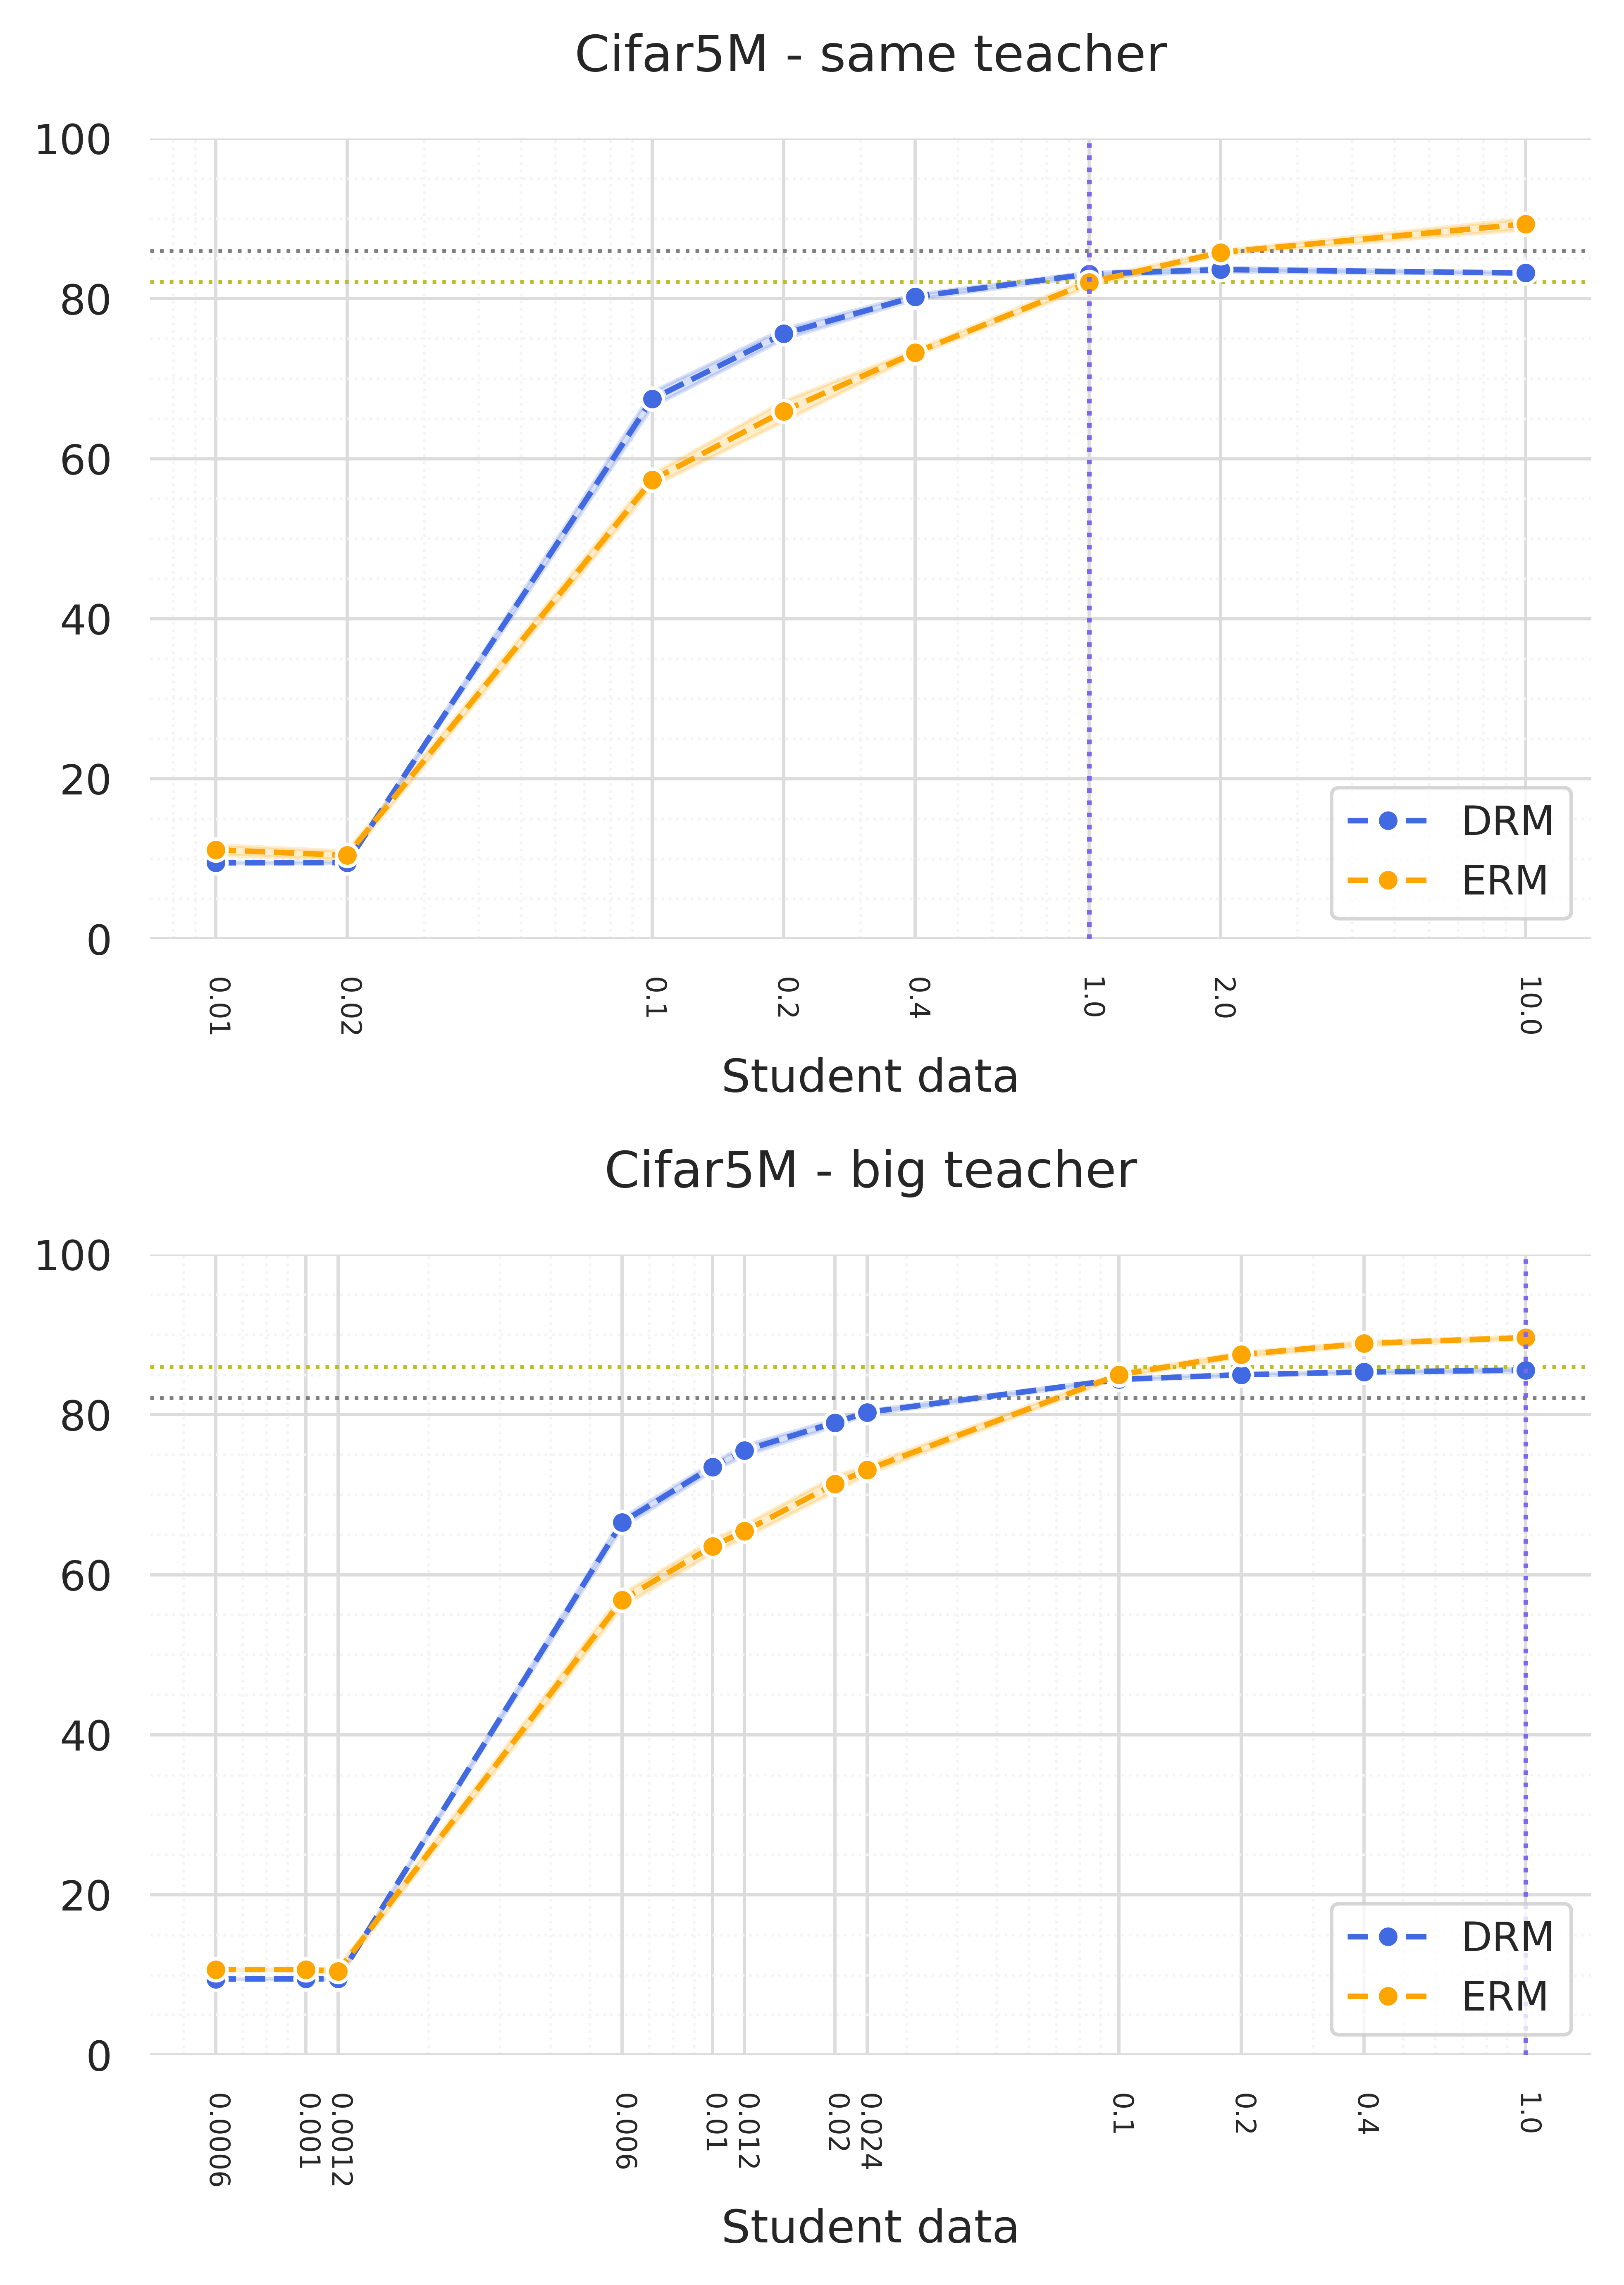

In [36]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(2, 1,  figsize=(5,7), sharex=False, sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']


    # ------------------------------- cifar 5m normal 

    ax[0].axhline(teacher_val_accuracy_sm, ls=':', color="tab:gray", linewidth=0.8)
    ax[0].axhline(teacher_val_accuracy, ls=':', color="tab:olive", linewidth=0.8)
    _df = working_df.loc[working_df['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='--',ax=ax[0], label="distil.val")
    _df = working_df.loc[working_df['alpha']==1.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='--', ax=ax[0], label="labels.val")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    # ax.axhline(76.034, ls='--', color=colors[2], label="a")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    ax[0].set_xscale('log')
    #ax.set_xscale('symlog',linthresh=10e-2)
    #ax[0].set_xlim([600, 1000000])
    #ax[0].set_ylim([0.0,100.0])

    ax[0].tick_params(axis='both',  labelsize=9)
    ax[0].set_xticks(buffer_sizes_p)
    ax[0].set_xticklabels(buffer_sizes_p, fontsize=6)
    ax[0].tick_params(axis='x',  rotation=-90)

    #yticks = [0.0, 25.0, 50.0, 75.0, teacher_val_accuracy, 100.0]
    #plt.yticks(yticks)
    #ax[0].set_yticklabels([0.0, 25.0, 50.0, 75.0, f'{teacher_val_accuracy}', 100.0], fontsize=8)

    ax[0].axvline(x=1.0, color='mediumslateblue', linewidth=1.0, linestyle=':')

    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax[0].set_title(f"Cifar5M - same teacher", fontsize=11, y=1.05)
    ax[0].set_ylabel(r'', fontsize=11, x=-0.2)
    ax[0].set_xlabel(r'Student data', fontsize=10, y=+2)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax[0].get_legend_handles_labels()
    ax[0].legend(h, ['DRM',
                  'ERM',
                  'teacher'], 
                title="", ncol=1, loc="lower right")


    # AESTHETICS control 
    ax[0].set_facecolor('white')
    [ax[0].spines[side].set_visible(False) for side in ax[0].spines]
    # major and minor grids
    ax[0].grid(which='major', color='gainsboro', linewidth=0.7)
    ax[0].grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax[0].minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    #sns.despine()




    # ------------------------------- cifar 5m small 

    ax[1].axhline(teacher_val_accuracy, ls=':', color="tab:gray", linewidth=0.8)
    ax[1].axhline(teacher_val_accuracy_sm, ls=':', color="tab:olive", linewidth=0.8)
    _df = working_df_sm.loc[working_df_sm['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='--',ax=ax[1], label="distil.val")
    _df = working_df_sm.loc[working_df_sm['alpha']==1.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='--', ax=ax[1], label="labels.val")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    ax[1].set_xscale('log')
    #ax.set_xscale('symlog',linthresh=10e-2)
    #ax.set_xlim([0.1,0.4])
    ax[1].set_ylim([0.0,100.0])

    ax[1].tick_params(axis='both',  labelsize=9)
    ax[1].set_xticks(buffer_sizes_p_sm)
    ax[1].set_xticklabels(buffer_sizes_p_sm, fontsize=6)
    ax[1].tick_params(axis='x',  rotation=-90)

    #yticks = [0.0, 25.0, 50.0, teacher_val_accuracy, teacher_val_accuracy_sm, 100.0]
    #plt.yticks(yticks)
    #ax[1].set_yticklabels([0.0, 25.0, 50.0, f'{teacher_val_accuracy}',f'{teacher_val_accuracy_sm}', 100.0], fontsize=8)

    ax[1].axvline(x=1.0, color='mediumslateblue', linewidth=1.0, linestyle=':')

    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax[1].set_title(f"Cifar5M - big teacher", fontsize=11, y=1.05)
    ax[1].set_ylabel(r'', fontsize=11, x=-0.2)
    ax[1].set_xlabel(r'Student data', fontsize=10, y=+2)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax[1].get_legend_handles_labels()
    ax[1].legend(h, ['DRM',
                  'ERM',
                  'teacher'], 
                title="", ncol=1, loc="lower right")


    # AESTHETICS control 
    ax[1].set_facecolor('white')
    [ax[1].spines[side].set_visible(False) for side in ax[1].spines]
    # major and minor grids
    ax[1].grid(which='major', color='gainsboro', linewidth=0.7)
    ax[1].grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax[1].minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)


    #sns.despine()

    plt.tight_layout()


# Cifar 5M recurrent

In [17]:
logs_path = './logs/results/cifar5m/mnet/logs.txt'
results = []
with open(logs_path) as f:
    while line := f.readline():
        results.append(json.loads(line))

In [18]:
res_df_rec = pd.DataFrame(results)
res_df_rec

distributed   lr  checkpoints  pretrained  optim_wd  optim_adam   
0            no  0.1         True       False     0.001       False  \
1            no  0.1         True       False     0.001       False   
2            no  0.1         True       False     0.001       False   
3            no  0.1         True       False     0.001       False   
4            no  0.1         True       False     0.001       False   
..          ...  ...          ...         ...       ...         ...   
115          no  0.1         True       False     0.001       False   
116          no  0.1         True       False     0.001       False   
117          no  0.1         True       False     0.001       False   
118          no  0.1         True       False     0.001       False   
119          no  0.1         True       False     0.001       False   

     optim_mom  optim_warmup  optim_nesterov  optim_cosineanneal  ...  gamma   
0            0             5           False                True  ...    1.0  \
1            0             5           False                True  ...    1.0   
2            0             5           False                True  ...    1.0   
3            0             5           False                True  ...    1.0   
4            0             5           False                True  ...    1.0   
..         ...           ...             ...                 ...  ...    ...   
115          0             5           False                True  ...    1.0   
116          0             5           False                True  ...    1.0   
117          0             5           False                True  ...    1.0   
118          0             5           False                True  ...    1.0   
119          0             5           False                True  ...    1.0   

     final_val_acc_D  buffer_train_time  final_train_acc_S final_val_acc_S   
0              82.07          75.188668          62.333333            9.47  \
1              82.07          75.562001          62.833333           11.80   
2              82.07          75.956750          47.000000            9.60   
3              82.07          77.219844          48.333333            9.47   
4              82.07          79.883052          62.833333           10.67   
..               ...                ...                ...             ...   
115            80.06        7845.311798          81.428333           81.06   
116            80.06        7856.710180          81.378833           81.27   
117            80.06        7935.874146          81.496833           80.92   
118            80.06        7979.876911          81.492500           81.31   
119            80.06        8071.068653          81.490000           80.97   

     final_train_agreement final_val_agreement  final_val_function_distance   
0                66.666667                9.08                     0.736977  \
1                55.000000               11.47                     0.737767   
2                44.333333                9.37                     0.737218   
3                54.833333                9.08                     0.738364   
4                56.166667               10.79                     0.737145   
..                     ...                 ...                          ...   
115              91.144833               92.04                     0.079198   
116              91.264667               91.94                     0.080256   
117              91.079667               91.95                     0.082448   
118              91.187167               91.95                     0.080379   
119              91.175333               92.27                     0.080845   

     final_distance_teacher_student  recurrence_level  
0                        176.803375               NaN  
1                        176.637573               NaN  
2                        176.684937               NaN  
3                        176.793655               NaN  
4                       

In [19]:
res_df_rec.columns

Index(['distributed', 'lr', 'checkpoints', 'pretrained', 'optim_wd',
       'optim_adam', 'optim_mom', 'optim_warmup', 'optim_nesterov',
       'optim_cosineanneal', 'n_epochs', 'n_epochs_stud', 'batch_size',
       'validate_subset', 'gpus_id', 'seed', 'notes', 'non_verbose',
       'disable_log', 'validation', 'ignore_other_metrics', 'debug_mode',
       'nowand', 'wandb_entity', 'wandb_project', 'wandb_name', 'buffer_size',
       'minibatch_size', 'alpha', 'MSE', 'distillation_type', 'K', 'N_BLOCKS',
       'gamma', 'final_val_acc_D', 'buffer_train_time', 'final_train_acc_S',
       'final_val_acc_S', 'final_train_agreement', 'final_val_agreement',
       'final_val_function_distance', 'final_distance_teacher_student',
       'recurrence_level'],
      dtype='object')

In [20]:
res_df_rec['buffer_size_p'] = res_df_rec['buffer_size']/60000
res_df_rec['generalization_gap'] = res_df_rec['final_val_acc_S']-res_df_rec['final_train_acc_S']
working_df_rec = res_df_rec
working_df_rec = working_df_rec.loc[working_df_rec['recurrence_level']==2] #HERE is the difference
#working_df_rec = working_df_rec.loc[working_df_rec['MSE'].isin([np.nan, False]),:] # removing all the runs that didn't work 
working_df_rec.head()

distributed   lr  checkpoints  pretrained  optim_wd  optim_adam  optim_mom   
80          no  0.1         True       False     0.001       False          0  \
81          no  0.1         True       False     0.001       False          0   
82          no  0.1         True       False     0.001       False          0   
83          no  0.1         True       False     0.001       False          0   
84          no  0.1         True       False     0.001       False          0   

    optim_warmup  optim_nesterov  optim_cosineanneal  ...  buffer_train_time   
80             5           False                True  ...          74.258482  \
81             5           False                True  ...          74.757548   
82             5           False                True  ...          75.622965   
83             5           False                True  ...          75.205173   
84             5           False                True  ...          78.432596   

    final_train_acc_S  final_val_acc_S  final_train_agreement   
80          43.166667             9.47              45.500000  \
81          61.333333             9.47              68.000000   
82          48.500000             9.47              51.500000   
83          51.333333             9.47              56.833333   
84          63.500000             9.47              67.333333   

   final_val_agreement  final_val_function_distance   
80                8.54                     0.725627  \
81                8.54                     0.727308   
82                8.54                     0.727106   
83                8.54                     0.726026   
84                8.54                     0.726984   

   final_distance_teacher_student  recurrence_level  buffer_size_p   
80                     190.946762               2.0           0.01  \
81                     190.976105               2.0           0.01   
82                     190.973724               2.0           0.01   
83                      48.854340               2.0           0.01   
84                     190.918457               2.0           0.01   

    generalization_gap  
80          -33.696667  
81          -51.863333  
82          -39.030000  
83          -41.863333  
84          -54.030000  

[5 rows x 45 columns]

In [21]:
teacher_val_accuracy_rec = list(working_df_rec['final_val_acc_D'])[0]
teacher_val_accuracy_rec

80.06

In [22]:
buffer_sizes_rec = sorted(working_df_rec['buffer_size'].unique())
buffer_sizes_rec

[600, 1200, 6000, 12000, 24000, 60000, 120000, 600000]

In [23]:
buffer_sizes_p_rec = sorted(working_df_rec['buffer_size_p'].unique())
buffer_sizes_p_rec

[0.01, 0.02, 0.1, 0.2, 0.4, 1.0, 2.0, 10.0]

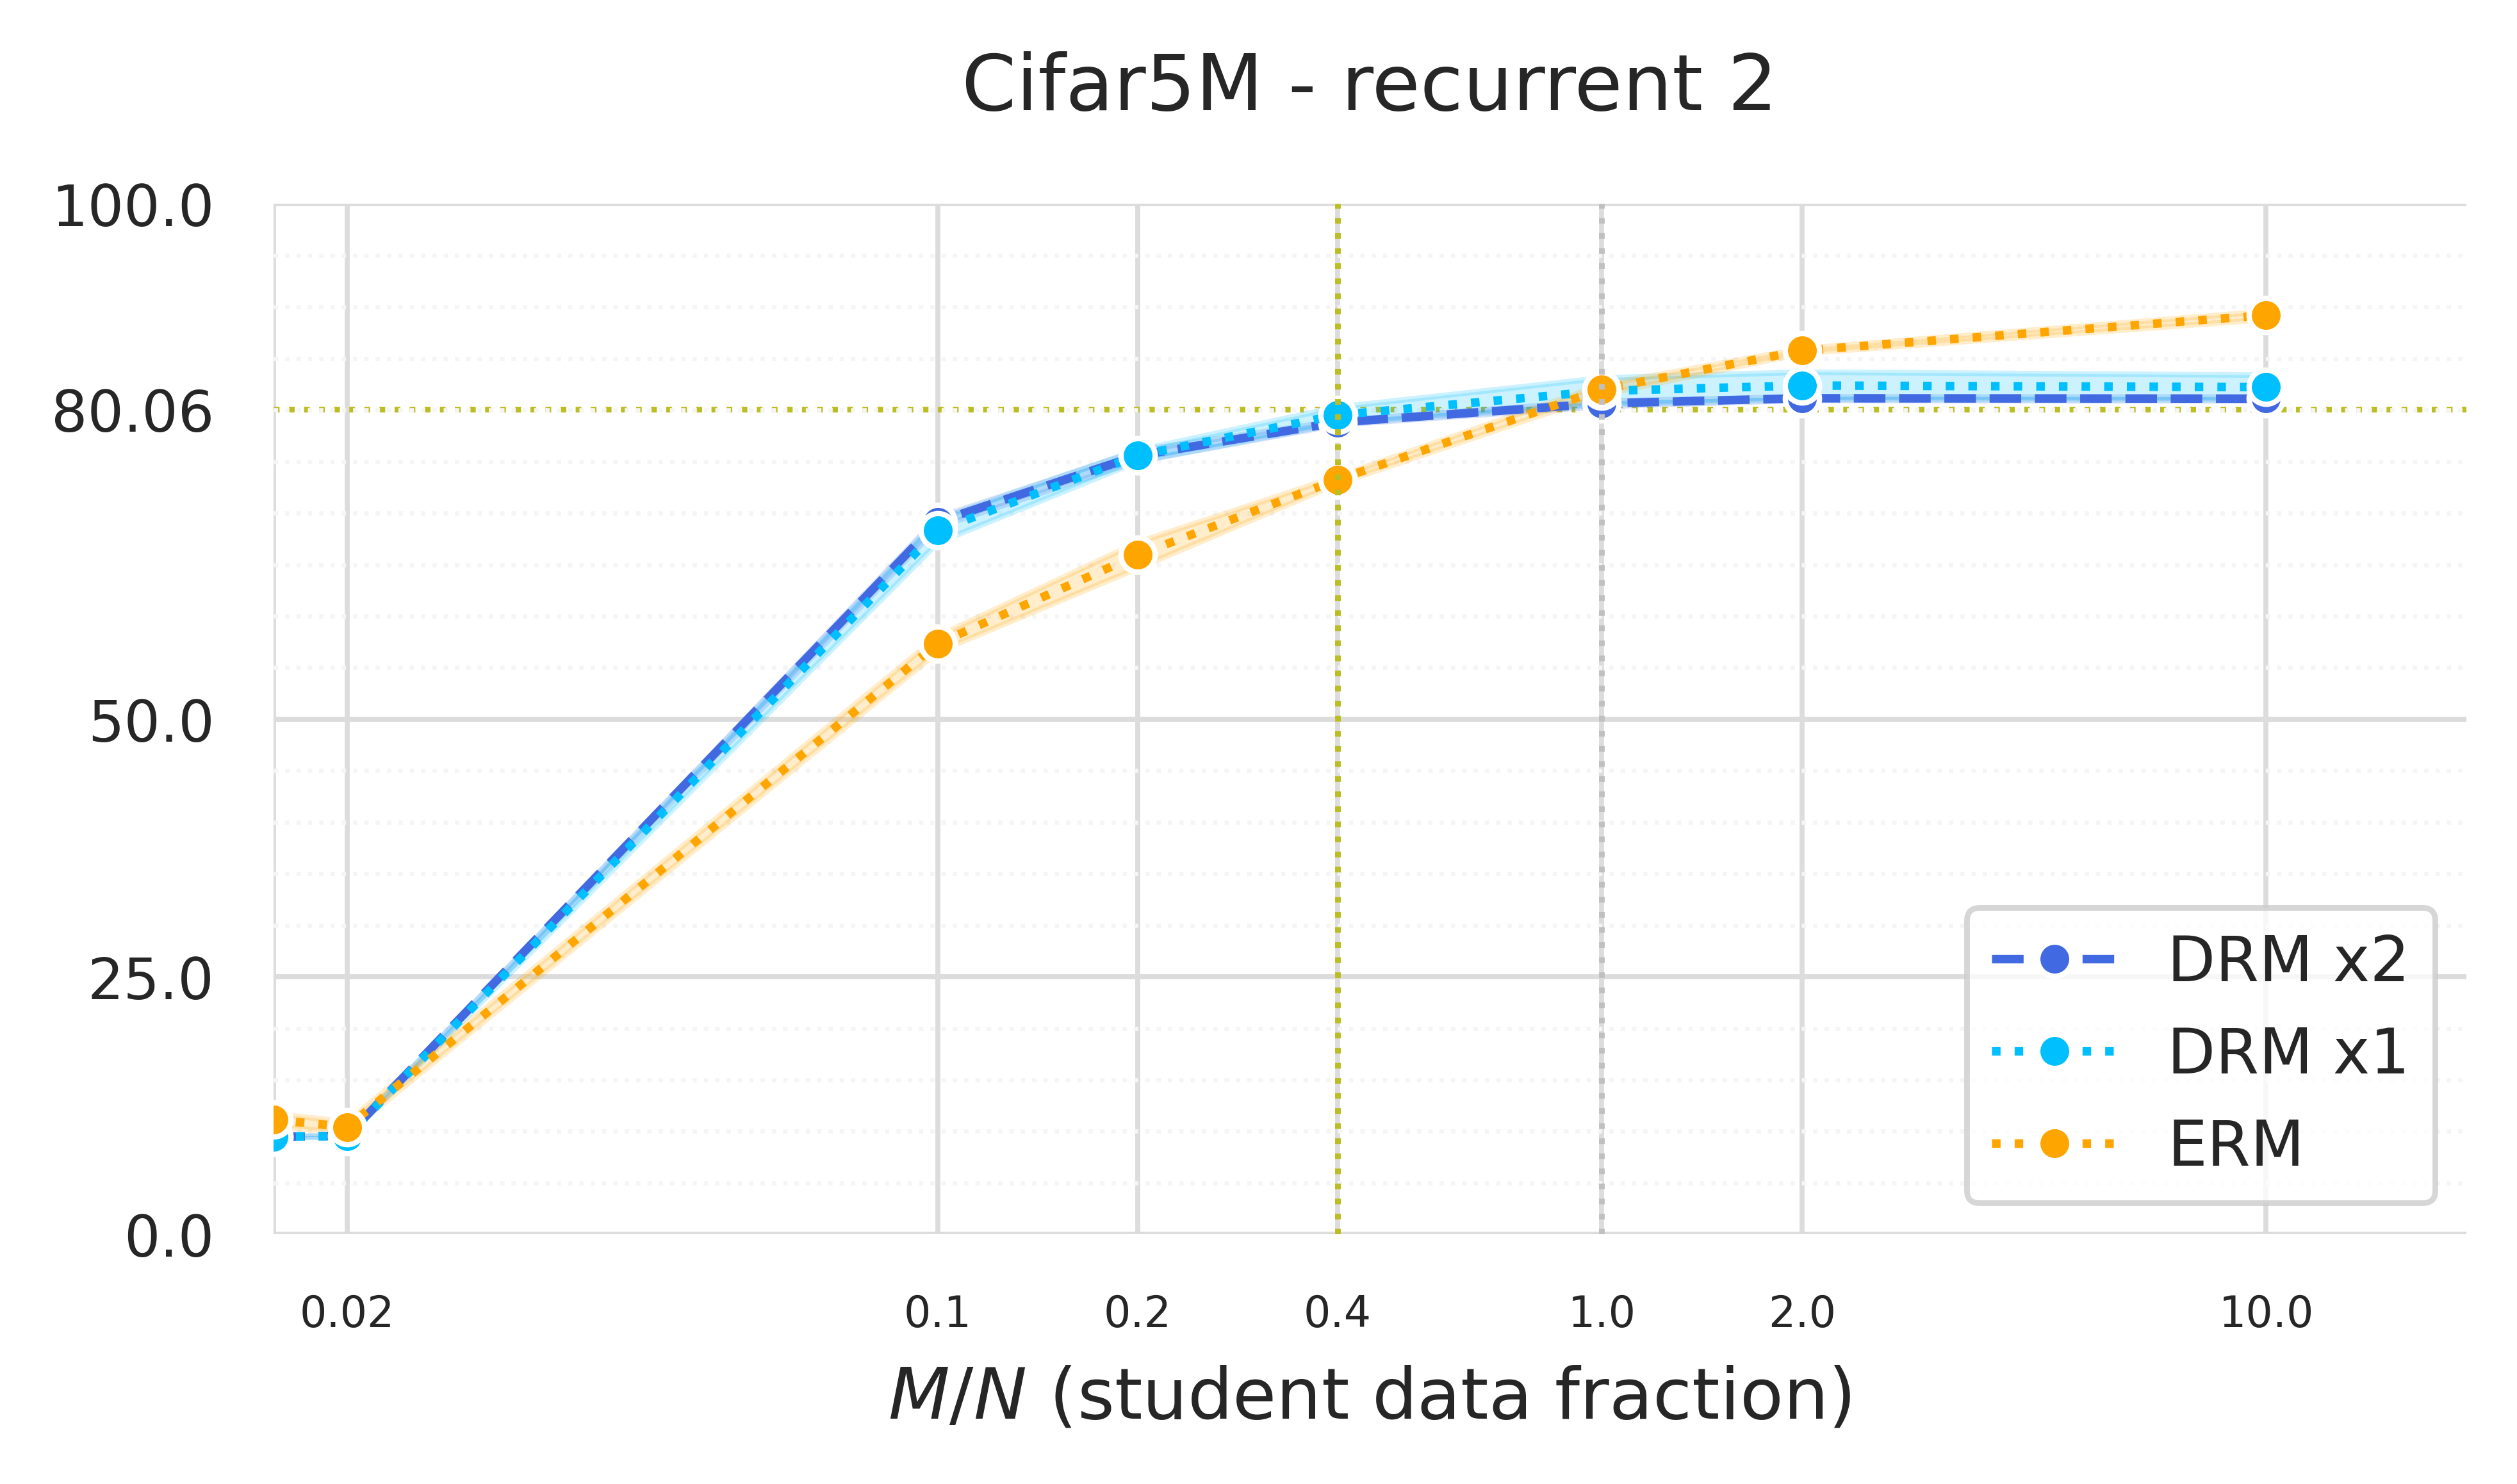

In [32]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,3), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']


    _df = working_df_rec.loc[working_df_rec['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='--',ax=ax, label="distil.val")
    _df = working_df.loc[working_df['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="sd",
                 markers=True, marker='o', color="deepskyblue", ls=':',ax=ax, label="distil.val")
    _df = working_df.loc[working_df['alpha']==1.0]
    sns.lineplot(data=_df, x="buffer_size_p", y="final_val_acc_S", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls=':', ax=ax, label="labels.val")
    

    ax.axvline(0.4, color='tab:olive', linewidth=0.8, linestyle=':')
    ax.axvline(1.0, color='silver', linewidth=0.8, linestyle=':')
    # ax.axhline(76.034, ls='--', color=colors[2], label="a")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    #ax.set_xscale('log')
    ax.set_xscale('symlog',linthresh=10e-2)
    ax.set_xlim([0.1,20.])
    ax.set_ylim([0.0,100.0])

    ax.tick_params(axis='both',  labelsize=9)
    ax.set_xticks(buffer_sizes_p_rec)
    ax.set_xticklabels(['']+[ f'{l}' for l in buffer_sizes_p_rec[1:]], fontsize=6)
    ax.tick_params(axis='x',  rotation=0)

    yticks = [0.0, 25.0, 50.0,teacher_val_accuracy_rec, 100.0]
    plt.yticks(yticks)
    ax.set_yticklabels([0.0, 25.0, 50.0, teacher_val_accuracy_rec, 100.0], fontsize=8)


    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax.set_title(f"Cifar5M - recurrent 2", fontsize=11, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'$M/N$ (student data fraction)', fontsize=10, y=+1)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, ['DRM x2',
                  'DRM x1',
                  'ERM'], 
                title="", ncol=1, loc="lower right")


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.7)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    a = ax.get_ygridlines()
    b = a[3]
    b.set_color('tab:olive')
    b.set_linewidth(0.8)
    b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()


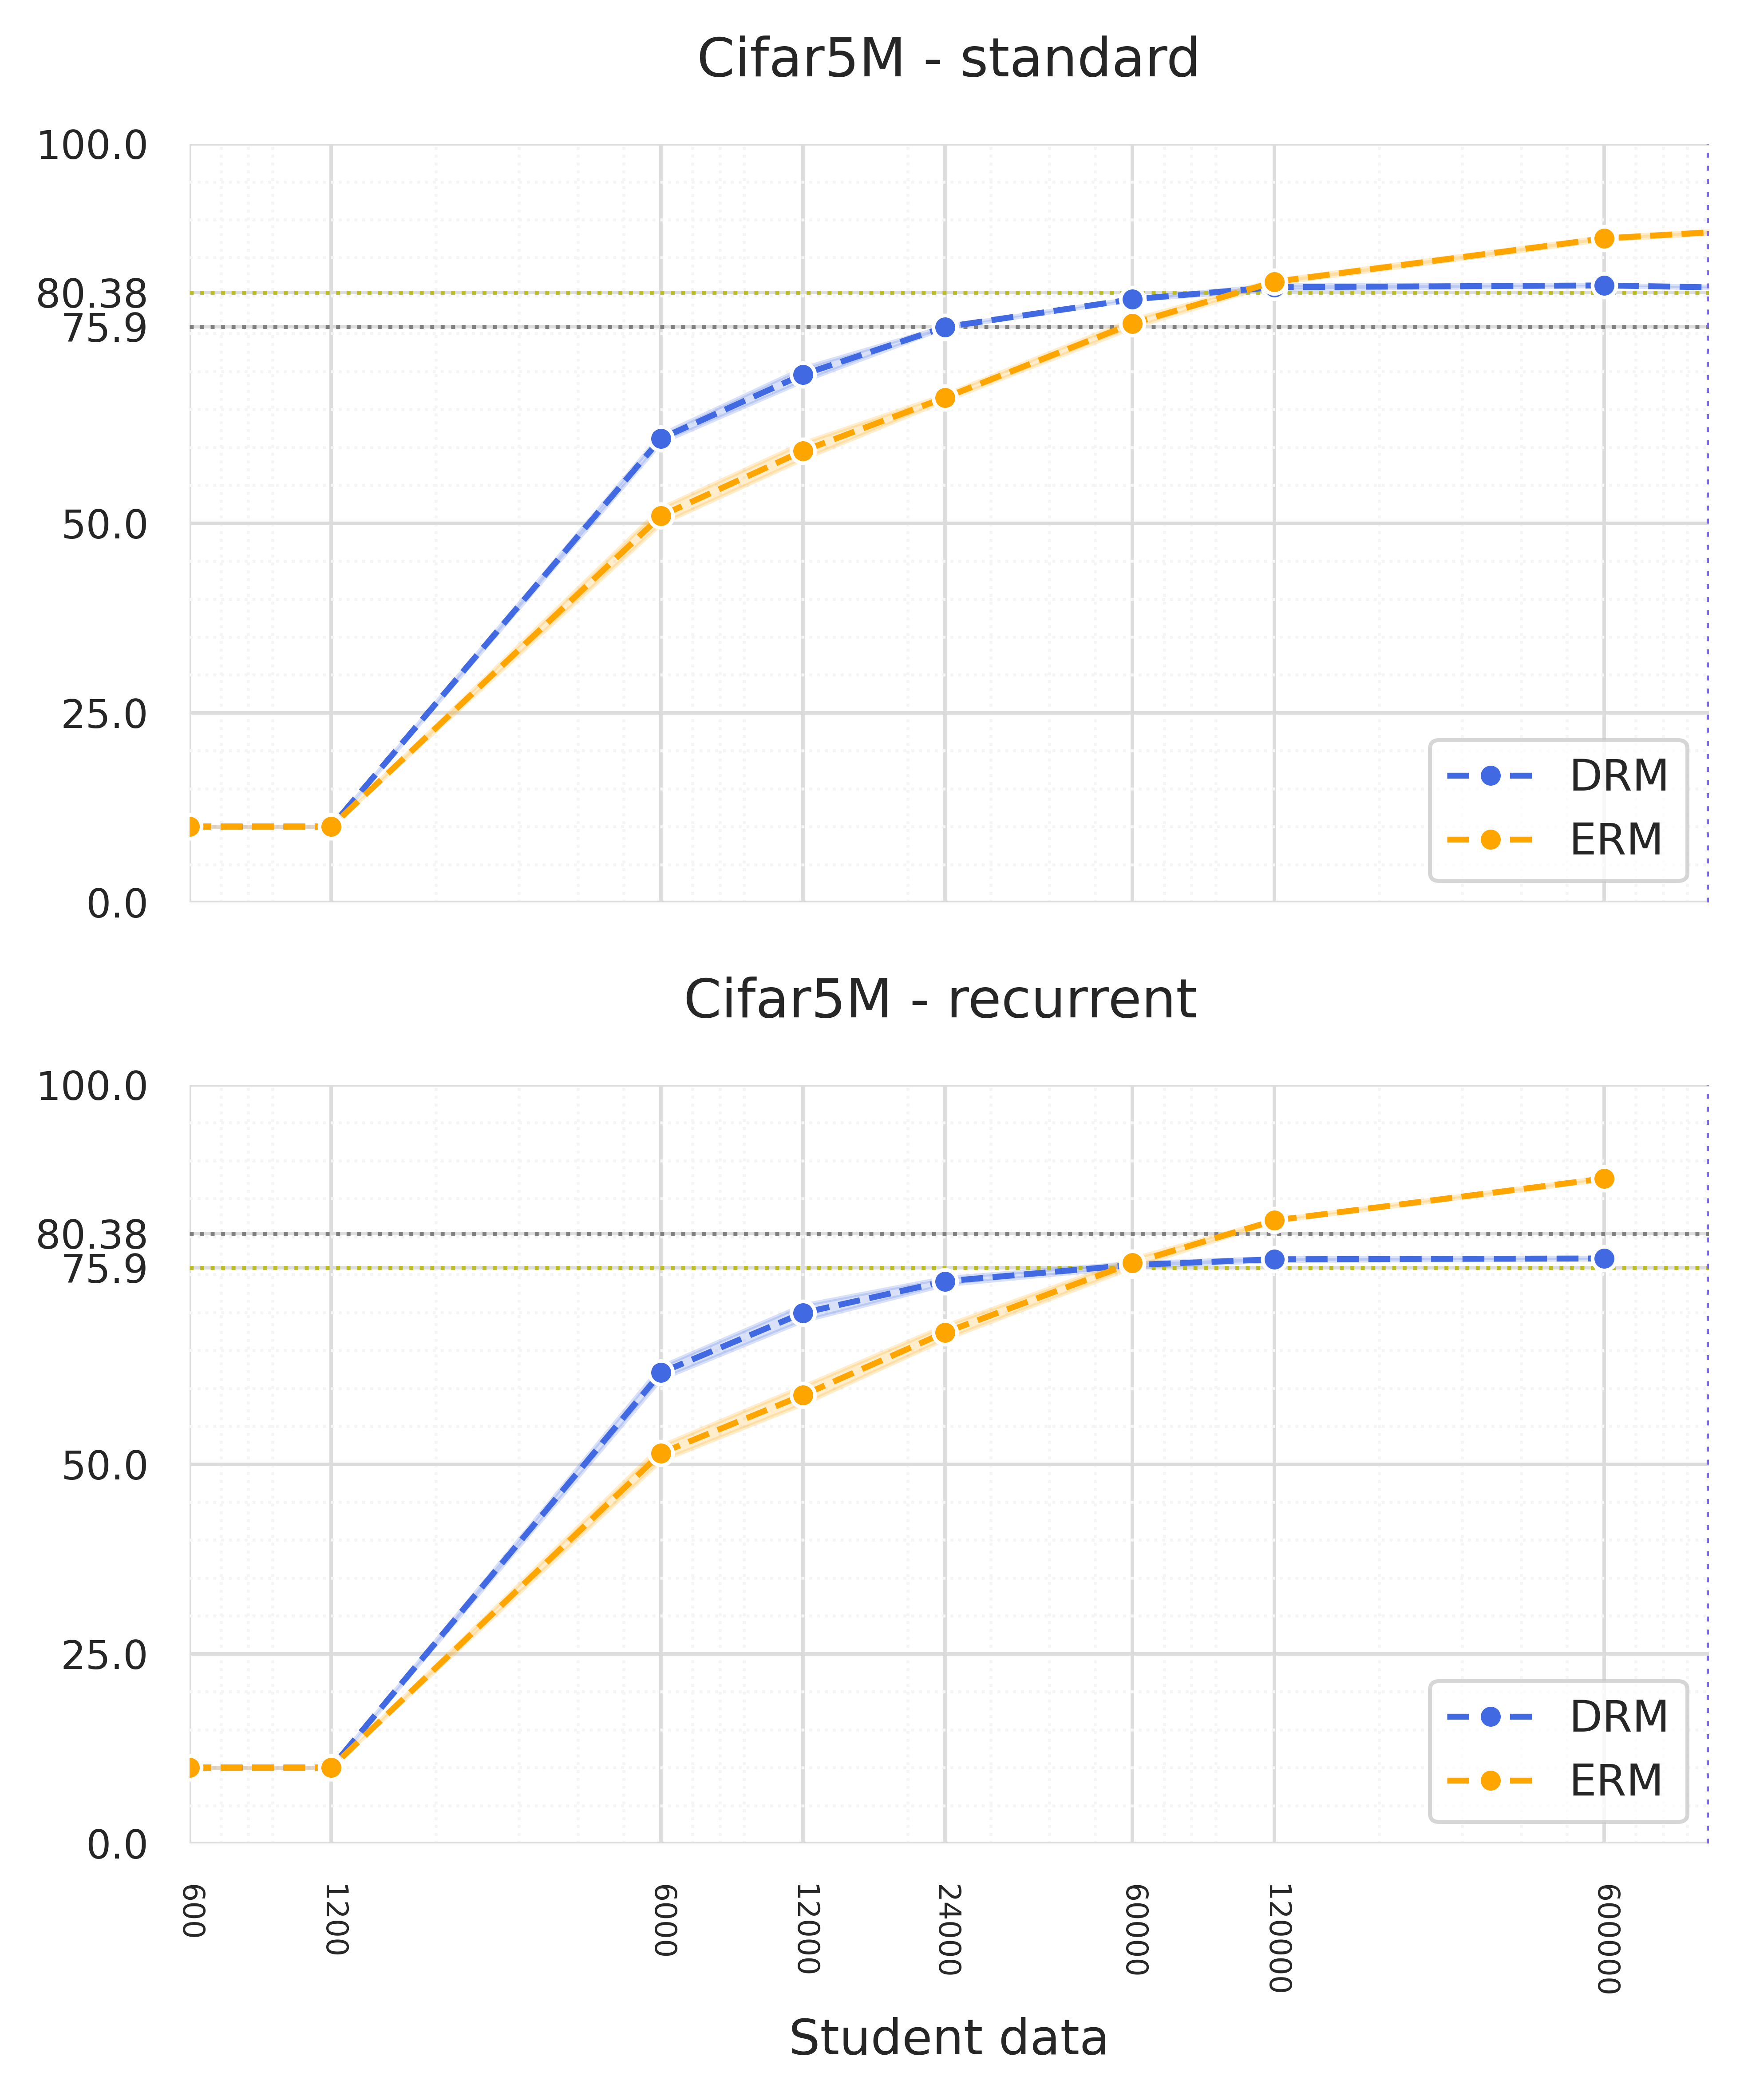

In [54]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(2, 1,  figsize=(5,6), sharex=True, sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']


    # ------------------------------- cifar 5m normal 

    ax[0].axhline(teacher_val_accuracy_rec, ls=':', color="tab:gray", linewidth=0.8)
    ax[0].axhline(teacher_val_accuracy, ls=':', color="tab:olive", linewidth=0.8)
    _df = working_df.loc[working_df['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size", y="final_val_acc_S", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='--',ax=ax[0], label="distil.val")
    _df = working_df.loc[working_df['alpha']==1.0]
    sns.lineplot(data=_df, x="buffer_size", y="final_val_acc_S", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='--', ax=ax[0], label="labels.val")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    # ax.axhline(76.034, ls='--', color=colors[2], label="a")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    ax[0].set_xscale('log')
    #ax.set_xscale('symlog',linthresh=10e-2)
    ax[0].set_xlim([600, 1000000])
    #ax[0].set_ylim([0.0,100.0])

    ax[0].tick_params(axis='both',  labelsize=9)
    ax[0].set_xticks(buffer_sizes)
    ax[0].set_xticklabels(buffer_sizes, fontsize=6)
    ax[0].tick_params(axis='x',  rotation=-90)

    yticks = [0.0, 25.0, 50.0, 75.0, teacher_val_accuracy, 100.0]
    plt.yticks(yticks)
    ax[0].set_yticklabels([0.0, 25.0, 50.0, 75.0, f'{teacher_val_accuracy}', 100.0], fontsize=8)

    ax[0].axvline(x=1000000, color='mediumslateblue', linewidth=1.0, linestyle=':')

    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax[0].set_title(f"Cifar5M - standard", fontsize=11, y=1.05)
    ax[0].set_ylabel(r'', fontsize=11, x=-0.2)
    ax[0].set_xlabel(r'Student data', fontsize=10, y=+2)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax[0].get_legend_handles_labels()
    ax[0].legend(h, ['DRM',
                  'ERM',
                  'teacher'], 
                title="", ncol=1, loc="lower right")


    # AESTHETICS control 
    ax[0].set_facecolor('white')
    [ax[0].spines[side].set_visible(False) for side in ax[0].spines]
    # major and minor grids
    ax[0].grid(which='major', color='gainsboro', linewidth=0.7)
    ax[0].grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax[0].minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    #sns.despine()




    # ------------------------------- cifar 5m small 

    ax[1].axhline(teacher_val_accuracy, ls=':', color="tab:gray", linewidth=0.8)
    ax[1].axhline(teacher_val_accuracy_rec, ls=':', color="tab:olive", linewidth=0.8)
    _df = working_df_rec.loc[working_df_rec['alpha']==0.0]
    sns.lineplot(data=_df, x="buffer_size", y="final_val_acc_S", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='--',ax=ax[1], label="distil.val")
    _df = working_df_rec.loc[working_df_rec['alpha']==1.0]
    sns.lineplot(data=_df, x="buffer_size", y="final_val_acc_S", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='--', ax=ax[1], label="labels.val")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    ax[1].set_xscale('log')
    #ax.set_xscale('symlog',linthresh=10e-2)
    #ax.set_xlim([0.1,0.4])
    ax[1].set_ylim([0.0,100.0])

    ax[1].tick_params(axis='both',  labelsize=9)
    ax[1].set_xticks(buffer_sizes_rec)
    ax[1].set_xticklabels(buffer_sizes_rec, fontsize=6)
    ax[1].tick_params(axis='x',  rotation=-90)

    yticks = [0.0, 25.0, 50.0, teacher_val_accuracy_rec, teacher_val_accuracy, 100.0]
    plt.yticks(yticks)
    ax[1].set_yticklabels([0.0, 25.0, 50.0, f'{teacher_val_accuracy_rec}',f'{teacher_val_accuracy}', 100.0], fontsize=8)

    ax[1].axvline(x=1000000, color='mediumslateblue', linewidth=1.0, linestyle=':')

    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax[1].set_title(f"Cifar5M - recurrent ", fontsize=11, y=1.05)
    ax[1].set_ylabel(r'', fontsize=11, x=-0.2)
    ax[1].set_xlabel(r'Student data', fontsize=10, y=+2)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax[1].get_legend_handles_labels()
    ax[1].legend(h, ['DRM',
                  'ERM',
                  'teacher'], 
                title="", ncol=1, loc="lower right")


    # AESTHETICS control 
    ax[1].set_facecolor('white')
    [ax[1].spines[side].set_visible(False) for side in ax[1].spines]
    # major and minor grids
    ax[1].grid(which='major', color='gainsboro', linewidth=0.7)
    ax[1].grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax[1].minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)


    #sns.despine()

    plt.tight_layout()
